# Data preparation

In [1]:
library(lubridate)  #work with dates
library(xts)
library(forecast)
lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "C") #needed for as.POSIXct


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



[1] "C"

In [2]:
data <- read.csv('bicup2006.csv',sep=',')
head(data)
dim(data)

DATE,TIME,DEMAND
1-Mar-05,6:30,1
1-Mar-05,6:45,2
1-Mar-05,7:00,4
1-Mar-05,7:15,0
1-Mar-05,7:30,10
1-Mar-05,7:45,13


[1] 1512    3

In [3]:
date.and.time<-paste(data$DATE,data$TIME) #combine date and time in one column

In [4]:
posix.date<-as.POSIXct(date.and.time,format="%d-%b-%y %H:%M")
#create new dataframe with columns posix.date and demand
newdataset<-data.frame(posix.date,data$DEMAND)
names(newdataset)<-c('date.and.time','demand')
head(newdataset)
dim(newdataset)

date.and.time,demand
2005-03-01 06:30:00,1
2005-03-01 06:45:00,2
2005-03-01 07:00:00,4
2005-03-01 07:15:00,0
2005-03-01 07:30:00,10
2005-03-01 07:45:00,13


[1] 1512    2

In [5]:
colSums(is.na(newdataset)) # check for NA values

date.and.time        demand 
            0           189

Those 189 NA values are for the future dates that we must predict.  
Therefore the first 1323 entries (1512-189) are the training and validation entries that we are going to use to create out model.

In [6]:
class(newdataset$date.and.time)
class(newdataset$demand)

[1] "POSIXct" "POSIXt"

[1] "integer"

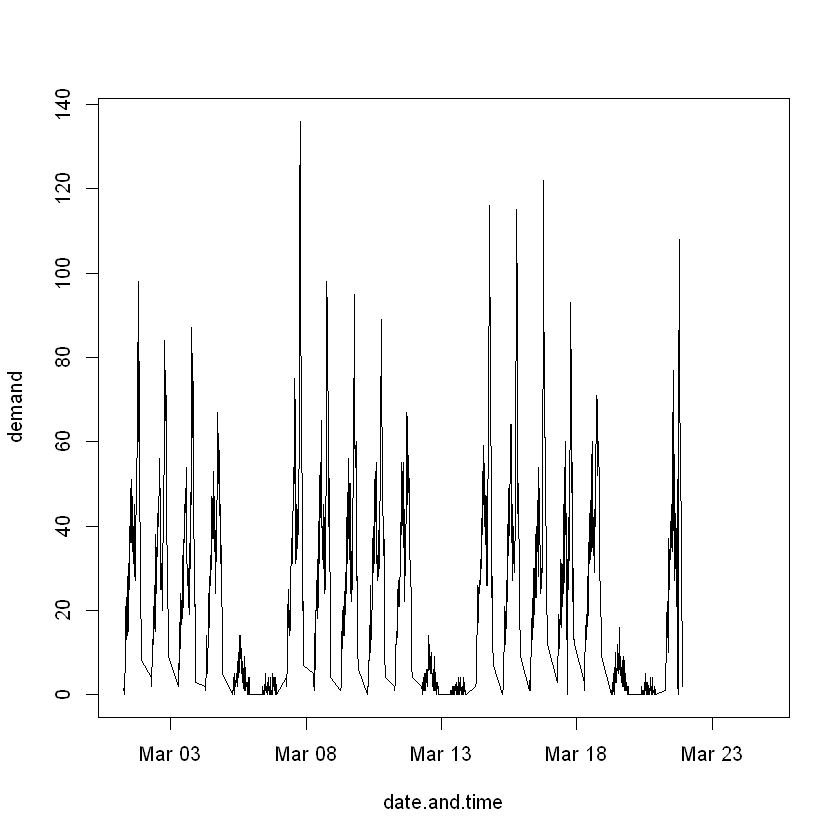

In [7]:
plot(newdataset,type='l')

Let's split the data to training and validation sets.The first 2 weeks are going to be for training and the 3rd week for validation.  
<img src="days.png">

Measurements are taken every 15 minutes from 6:30 to 22:00.Therefore, we have 15 and a half hours of measurements every 15 minutes which gives us 15.5*4 =62 measurements per day (since there are 4 quarters in an hour).  
We are going to use Mar 1 to Mar 14 as training and Mar 15 to Mar 21 as validation.The rest 3 days are left for prediction.

In [8]:
#indexes for first two weeks
training.set<-newdataset[1:(14*63),]
#indexes for last week
validation.set<-newdataset[((14*63)+1):(21*63),]
#indexes for last 3 days
future.set<-newdataset[((21*63)+1):dim(newdataset)[1],]

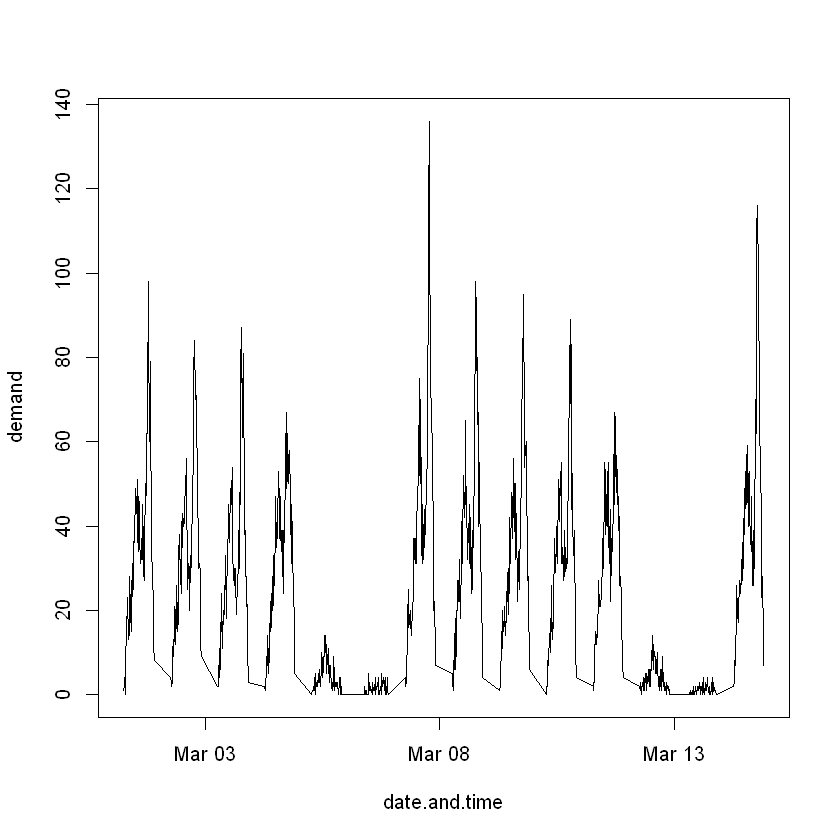

In [9]:
plot(training.set,type='l')

In [10]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))

In [11]:
attr(my.xts,"frequency")<-63
periodicity(my.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

The xts class gives us a lot of very useful features.Look how easy it is to get all values of March 12th,from 12:30 to 14:30.

In [12]:
my.xts["20050312 1230/20050312 1430"]

                    [,1]
2005-03-12 12:30:00    7
2005-03-12 12:45:00   14
2005-03-12 13:00:00   10
2005-03-12 13:15:00    6
2005-03-12 13:30:00   12
2005-03-12 13:45:00    9
2005-03-12 14:00:00    9
2005-03-12 14:15:00    9
2005-03-12 14:30:00    5

First weekend values.Get first week and then last two days.As we can see,weekend transportation is very limited.

In [13]:
last(first(my.xts,"week"),"2 days")

                    [,1]
2005-03-05 06:30:00    0
2005-03-05 06:45:00    1
2005-03-05 07:00:00    1
2005-03-05 07:15:00    1
2005-03-05 07:30:00    2
2005-03-05 07:45:00    1
2005-03-05 08:00:00    4
2005-03-05 08:15:00    0
2005-03-05 08:30:00    5
2005-03-05 08:45:00    1
2005-03-05 09:00:00    3
2005-03-05 09:15:00    2
2005-03-05 09:30:00    3
2005-03-05 09:45:00    2
2005-03-05 10:00:00    5
2005-03-05 10:15:00    3
2005-03-05 10:30:00    3
2005-03-05 10:45:00    6
2005-03-05 11:00:00    2
2005-03-05 11:15:00    3
2005-03-05 11:30:00    6
2005-03-05 11:45:00   10
2005-03-05 12:00:00    8
2005-03-05 12:15:00    4
2005-03-05 12:30:00    6
2005-03-05 12:45:00    9
2005-03-05 13:00:00    9
2005-03-05 13:15:00   14
2005-03-05 13:30:00   14
2005-03-05 13:45:00   10
2005-03-05 14:00:00   12
2005-03-05 14:15:00    5
2005-03-05 14:30:00    9
2005-03-05 14:45:00    8
2005-03-05 15:00:00   11
2005-03-05 15:15:00    5
2005-03-05 15:30:00    7
2005-03-05 15:45:00    3
2005-03-05 16:00:00    7


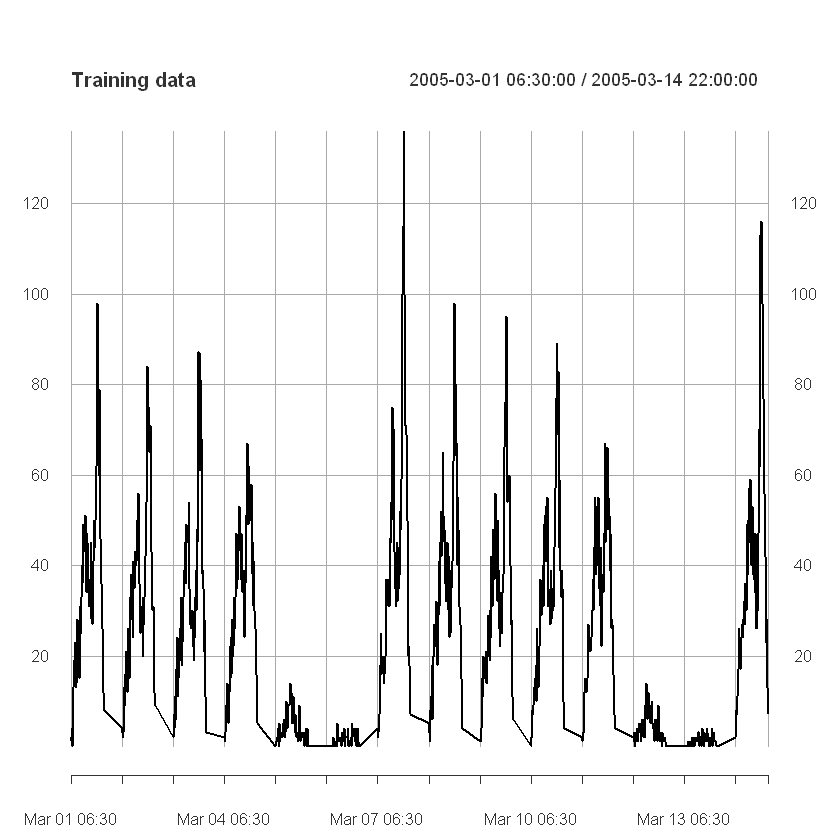

In [14]:
plot(my.xts,type='l',main='Training data')

In [15]:
summary(coredata(my.xts))

       V1        
 Min.   :  0.00  
 1st Qu.:  4.00  
 Median : 23.00  
 Mean   : 25.83  
 3rd Qu.: 40.00  
 Max.   :136.00  

In [16]:
#get daily stats.its easy to see which days are the weekends by the high values
daily<-to.period(my.xts,period = "days")
daily

                    my.xts.Open my.xts.High my.xts.Low my.xts.Close
2005-03-01 22:00:00           1          98          0            8
2005-03-02 22:00:00           4          84          2            9
2005-03-03 22:00:00           2          87          2            3
2005-03-04 22:00:00           2          67          1            5
2005-03-05 22:00:00           0          14          0            0
2005-03-06 22:00:00           0           5          0            0
2005-03-07 22:00:00           4         136          2            7
2005-03-08 22:00:00           5          98          1            4
2005-03-09 22:00:00           1          95          1            6
2005-03-10 22:00:00           0          89          0            4
2005-03-11 22:00:00           2          67          1            4
2005-03-12 22:00:00           2          14          0            0
2005-03-13 22:00:00           0           4          0            0
2005-03-14 22:00:00           2         116     

# Linear models with polynomial trend and seasonality 

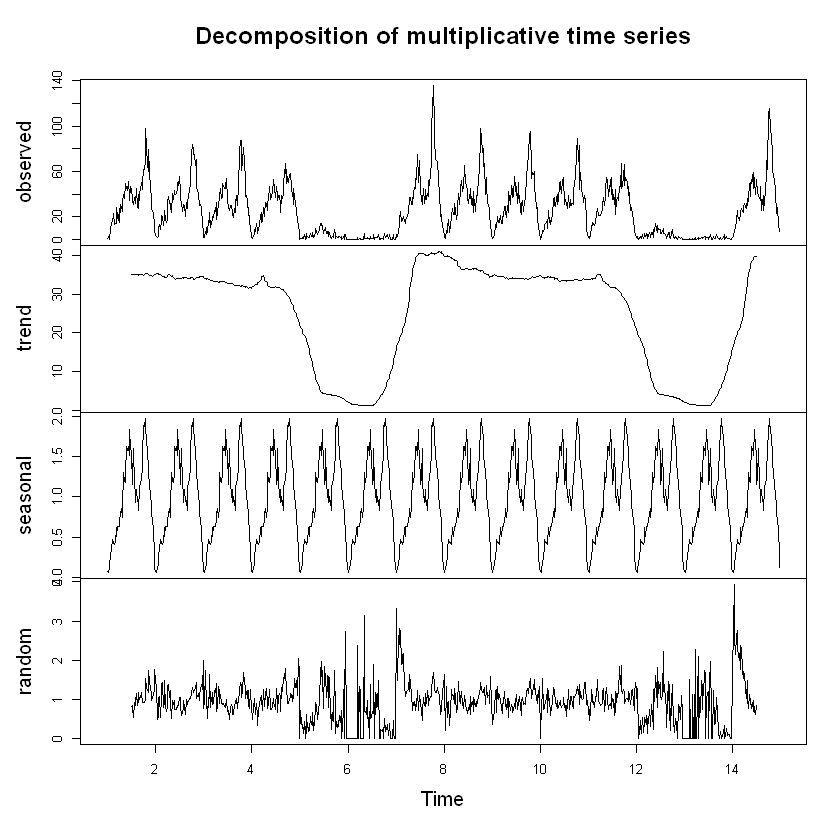

In [14]:
timeseries<-as.ts(my.xts)
#boxplot(timeseries~cycle(timeseries))

plot(decompose(timeseries,"multiplicative"))

In [18]:
model<-tslm(timeseries ~ trend +I(trend^2)+I(trend^3))
summary(model)


Call:
tslm(formula = timeseries ~ trend + I(trend^2) + I(trend^3))

Residuals:
    Min      1Q  Median      3Q     Max 
-34.835 -21.153  -3.752  13.748 111.201 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.510e+01  3.131e+00  11.210   <2e-16 ***
trend       -6.753e-02  3.069e-02  -2.200   0.0281 *  
I(trend^2)   1.426e-04  8.075e-05   1.766   0.0777 .  
I(trend^3)  -9.602e-08  6.012e-08  -1.597   0.1106    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 23.15 on 878 degrees of freedom
Multiple R-squared:  0.01394,	Adjusted R-squared:  0.01057 
F-statistic: 4.137 on 3 and 878 DF,  p-value: 0.006333


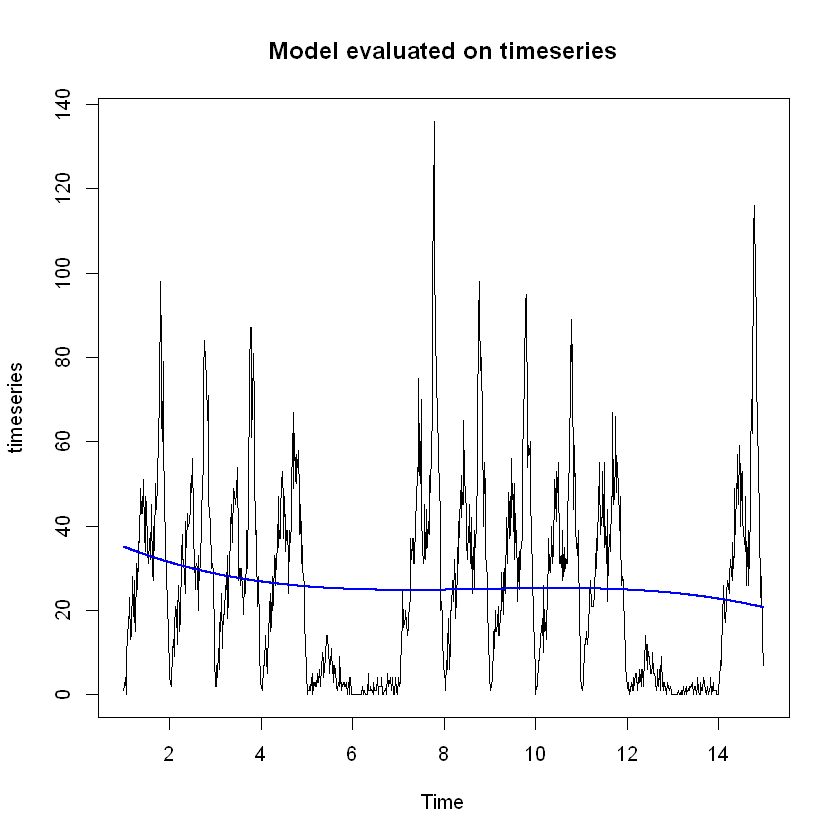

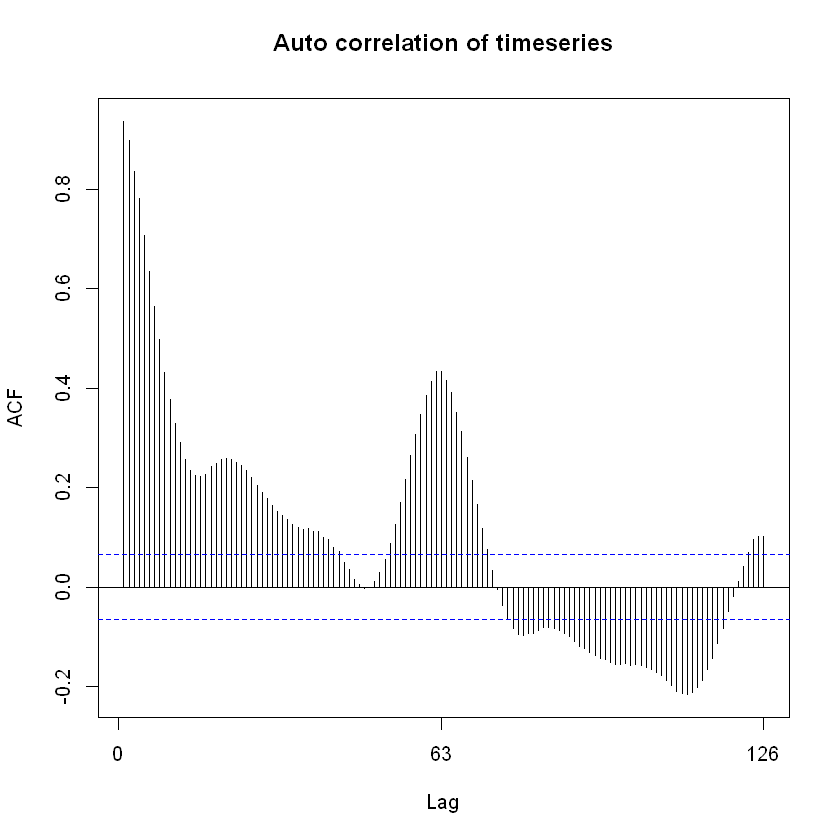

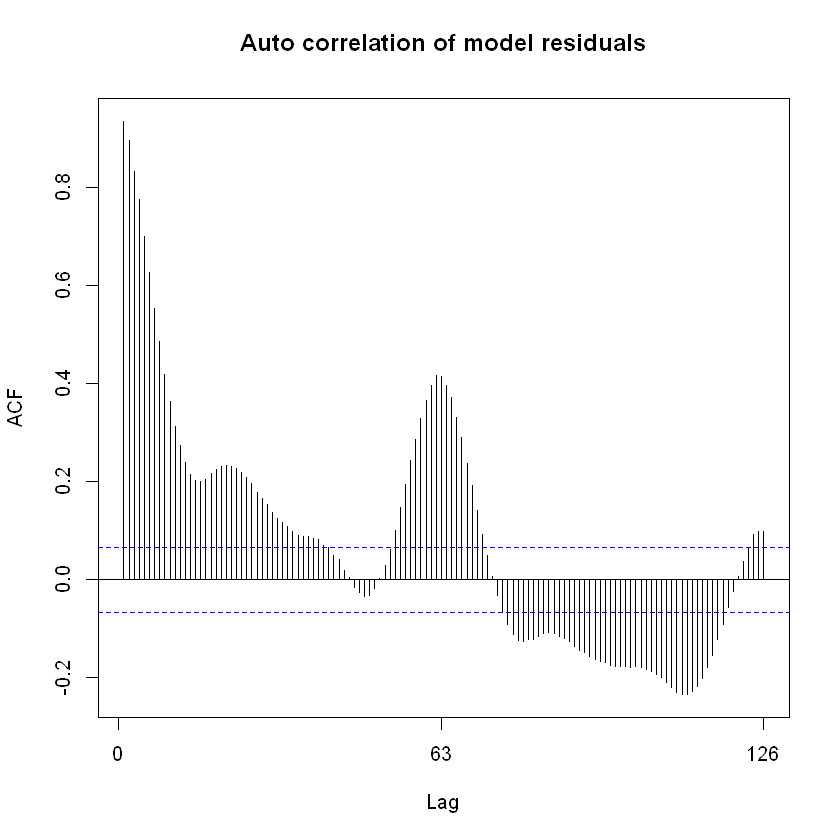

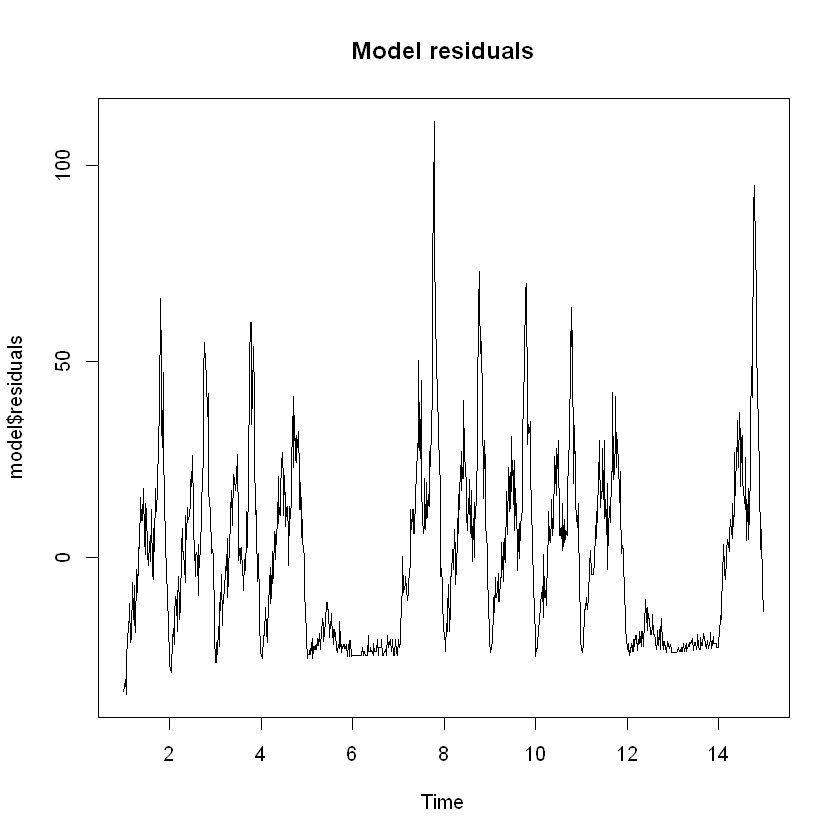

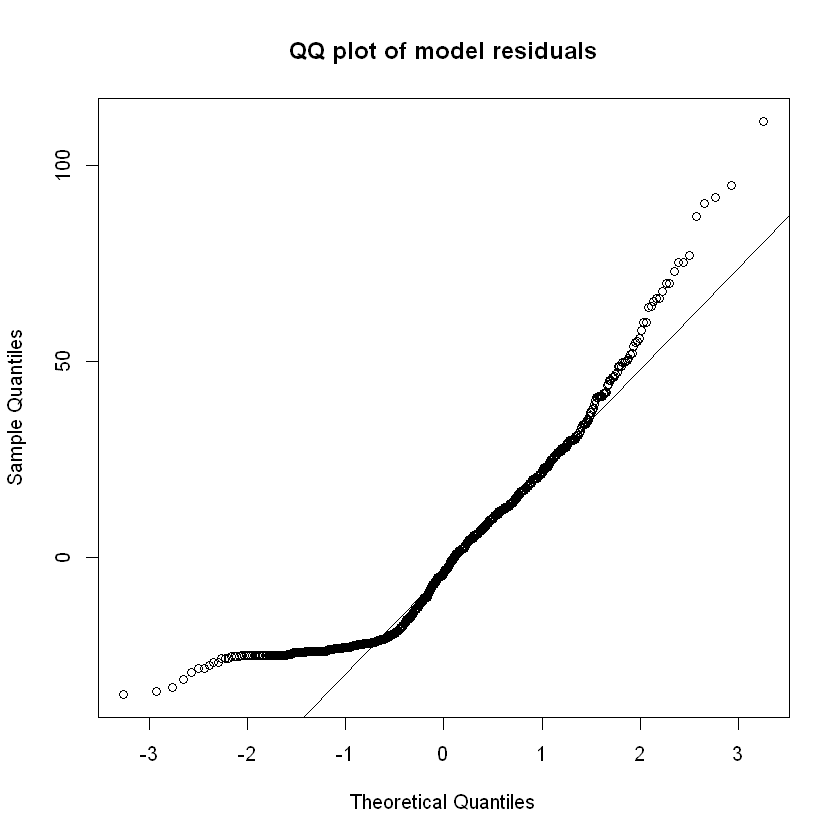

In [23]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(model$residuals,main='Auto correlation of model residuals')
plot(model$residuals,main='Model residuals')
qqnorm(model$residuals,main='QQ plot of model residuals')
qqline(model$residuals)

In [24]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

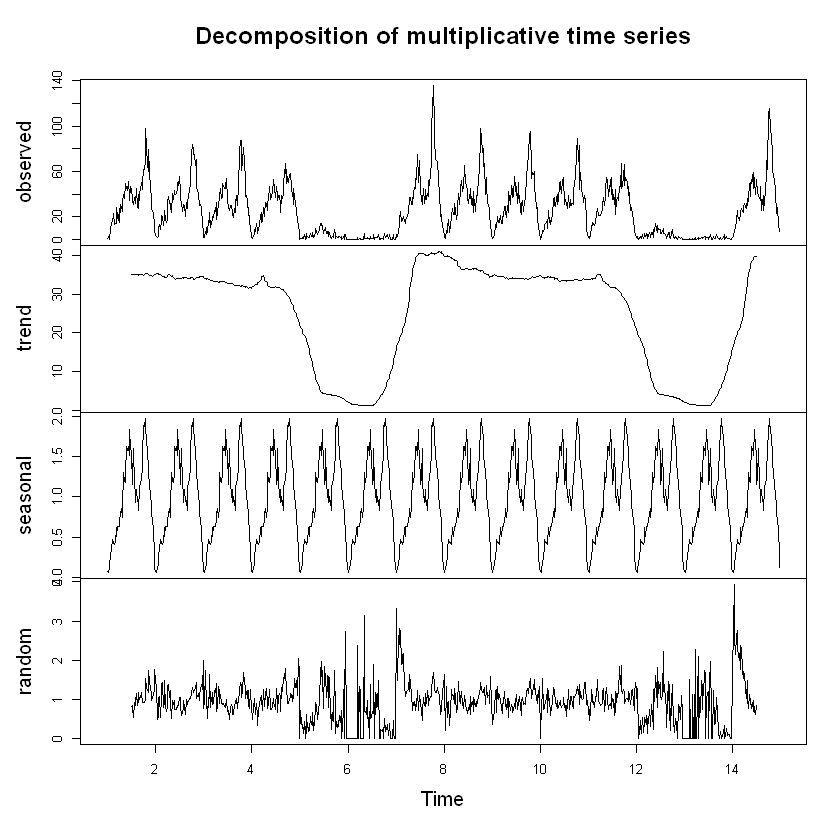

In [25]:
timeseries<-as.ts(my.xts)
#boxplot(timeseries~cycle(timeseries))

plot(decompose(timeseries,"multiplicative"))

In [26]:
model<-tslm(timeseries ~I(trend^4)  + season)
#model<-msts(timeseries, seasonal.periods=c(24*2,48*7))
summary(model)


Call:
tslm(formula = timeseries ~ I(trend^4) + season)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.528  -8.256   3.105  10.321  71.823 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.189e+00  5.084e+00   0.627 0.530641    
I(trend^4)  -1.389e-11  3.959e-12  -3.509 0.000475 ***
season2     -2.060e-01  7.168e+00  -0.029 0.977079    
season3      1.017e+00  7.168e+00   0.142 0.887254    
season4      1.811e+00  7.168e+00   0.253 0.800638    
season5      5.605e+00  7.168e+00   0.782 0.434490    
season6      7.185e+00  7.168e+00   1.002 0.316486    
season7      1.062e+01  7.168e+00   1.482 0.138774    
season8      8.987e+00  7.168e+00   1.254 0.210269    
season9      1.057e+01  7.168e+00   1.474 0.140804    
season10     9.647e+00  7.168e+00   1.346 0.178713    
season11     9.942e+00  7.168e+00   1.387 0.165836    
season12     1.395e+01  7.168e+00   1.946 0.051974 .  
season13     1.360e+01  7.168e+00   1.898 0.058104 .  
season14  

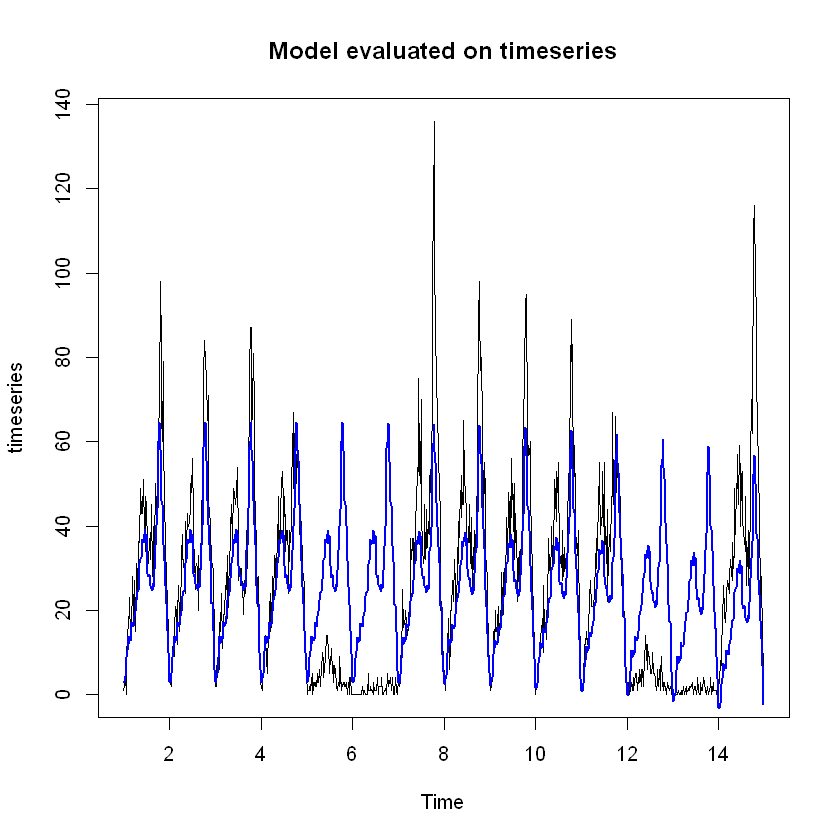

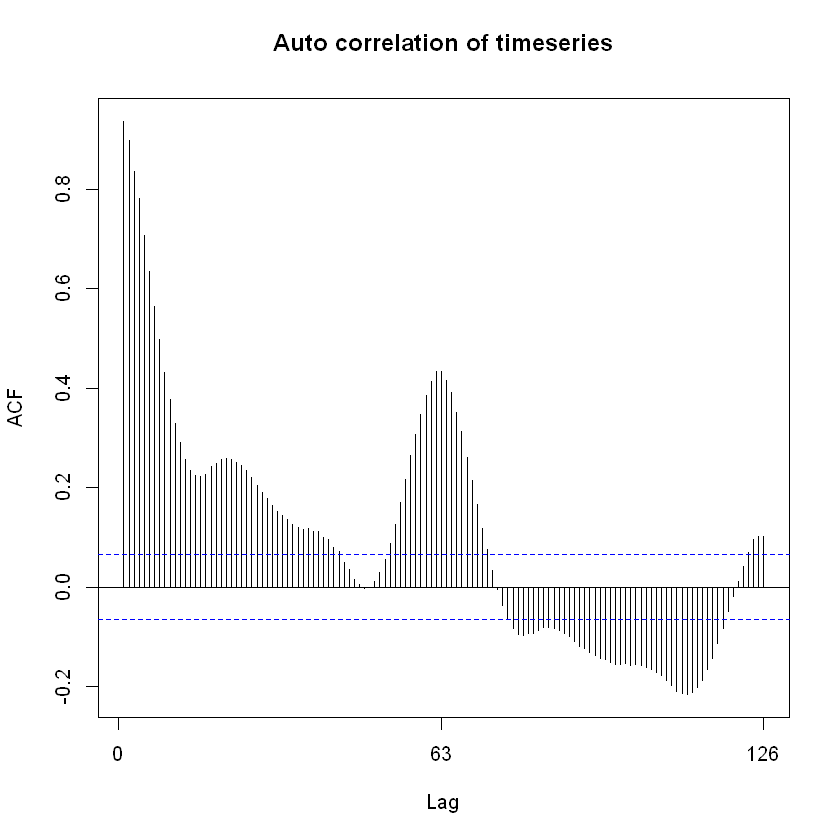

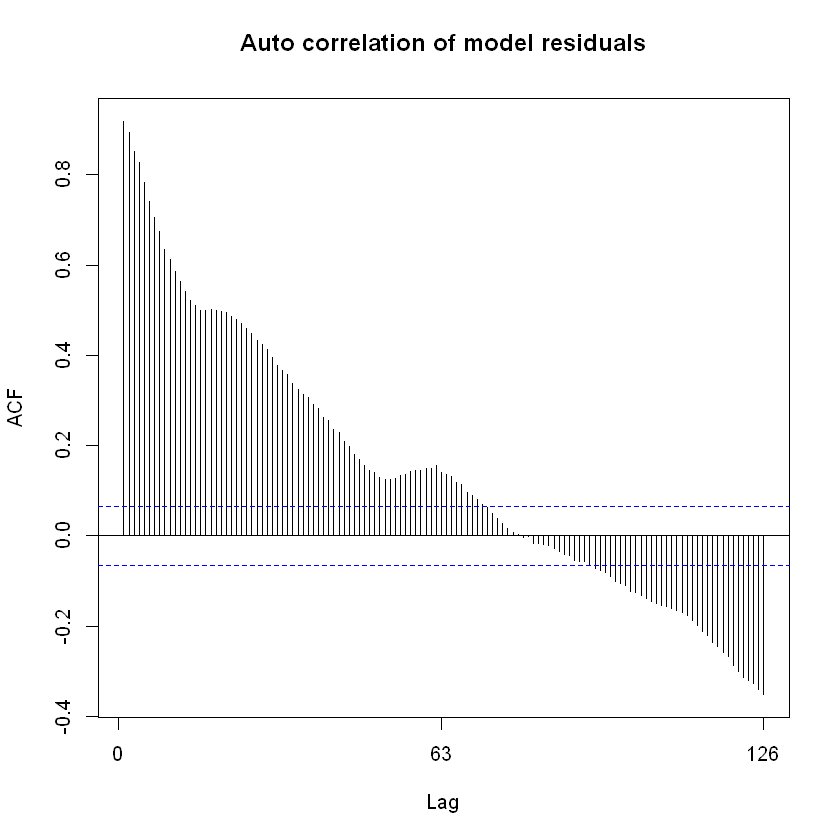

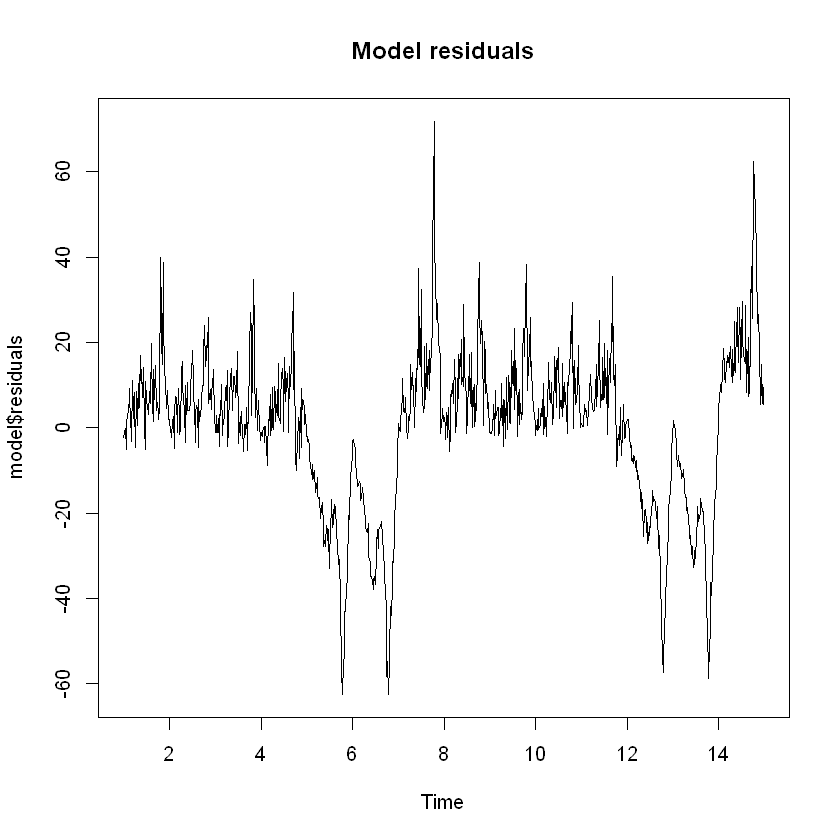

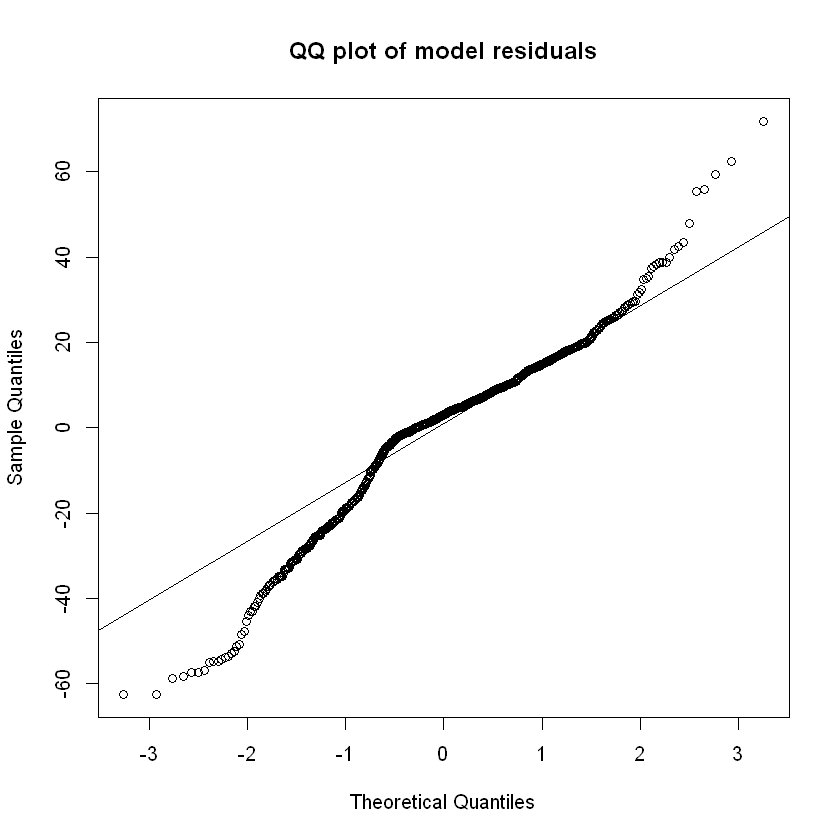

In [27]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(model$residuals,main='Auto correlation of model residuals')
plot(model$residuals,main='Model residuals')
qqnorm(model$residuals,main='QQ plot of model residuals')
qqline(model$residuals)

In [28]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

In [29]:
multiple<-msts(timeseries, seasonal.periods=c(7,63))


Call:
tslm(formula = multiple ~ trend + season)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.552  -7.956   2.611  10.487  72.861 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.389674   5.148530   1.241 0.214937    
trend       -0.011215   0.002503  -4.481 8.48e-06 ***
season2     -0.203070   7.134681  -0.028 0.977300    
season3      1.022431   7.134682   0.143 0.886085    
season4      1.819361   7.134684   0.255 0.798785    
season5      5.616291   7.134687   0.787 0.431404    
season6      7.198935   7.134691   1.009 0.313271    
season7     10.638722   7.134696   1.491 0.136314    
season8      9.007080   7.134702   1.262 0.207153    
season9     10.589724   7.134708   1.484 0.138127    
season10     9.672368   7.134716   1.356 0.175576    
season11     9.969298   7.134724   1.397 0.162704    
season12    13.980513   7.134733   1.960 0.050393 .  
season13    13.634586   7.134743   1.911 0.056352 .  
season14    13.074373   7.134754

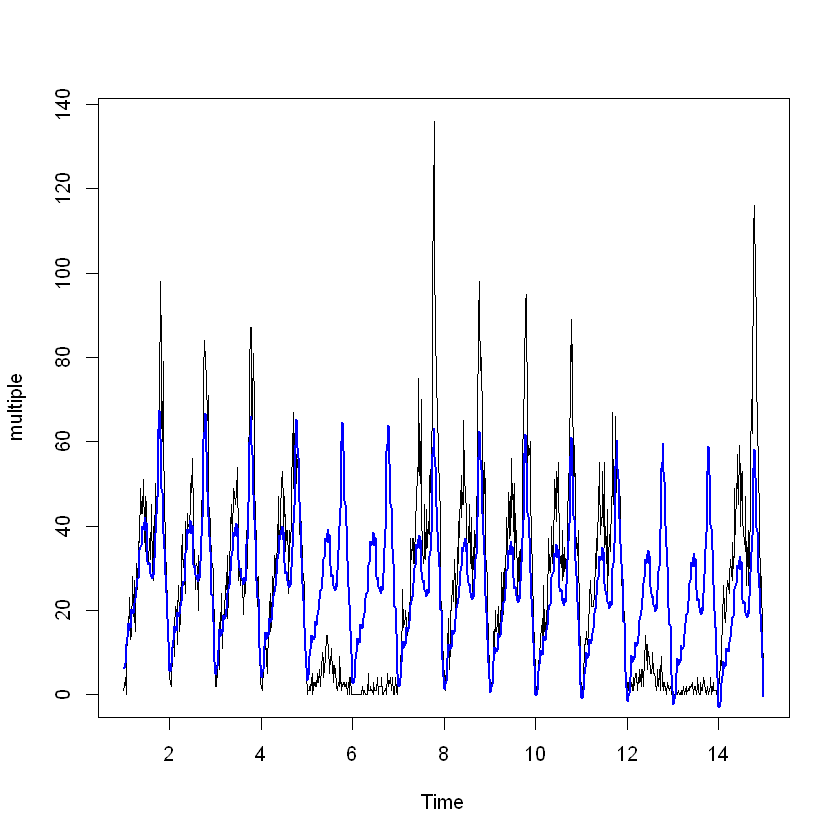

In [30]:
model<-tslm(multiple ~trend  + season)
#model<-msts(timeseries, seasonal.periods=c(24*2,48*7))
summary(model)
plot(multiple)
lines(model$fitted, lwd = 2,col='blue')

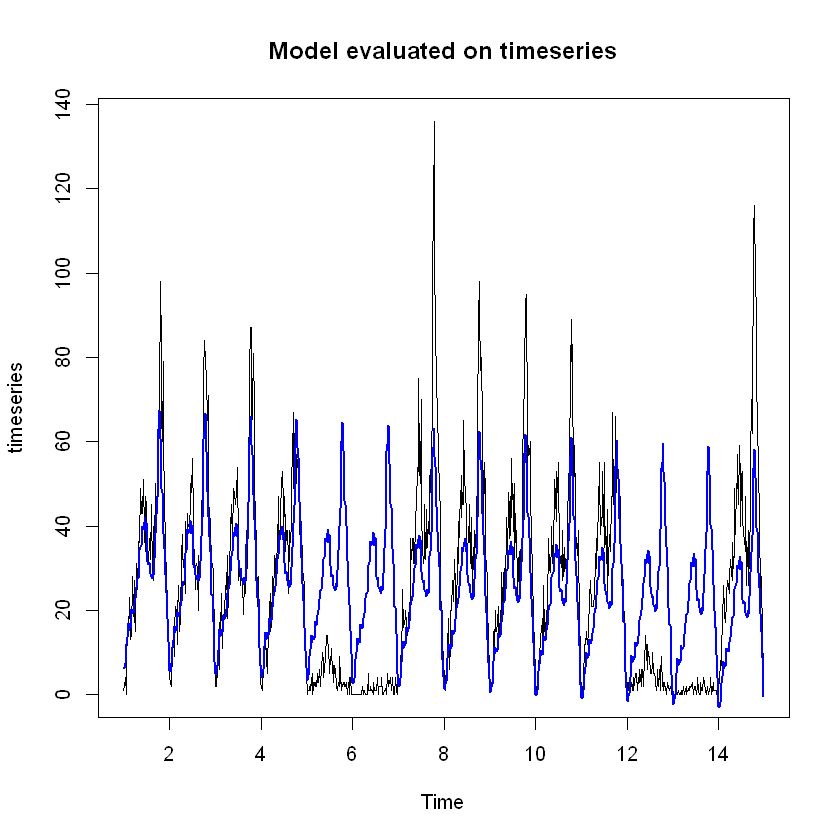

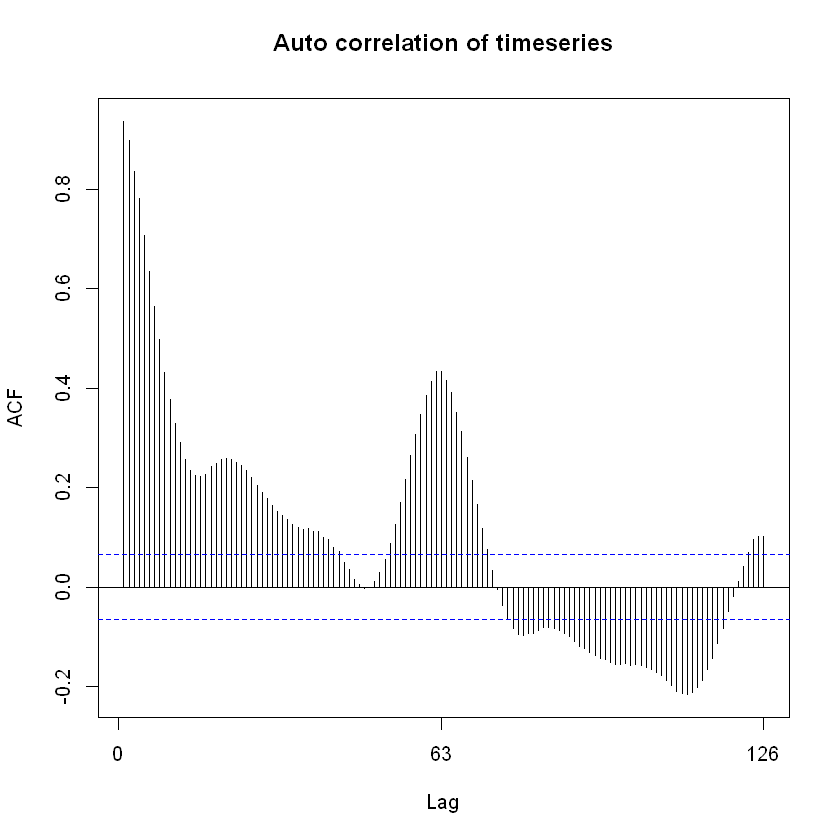

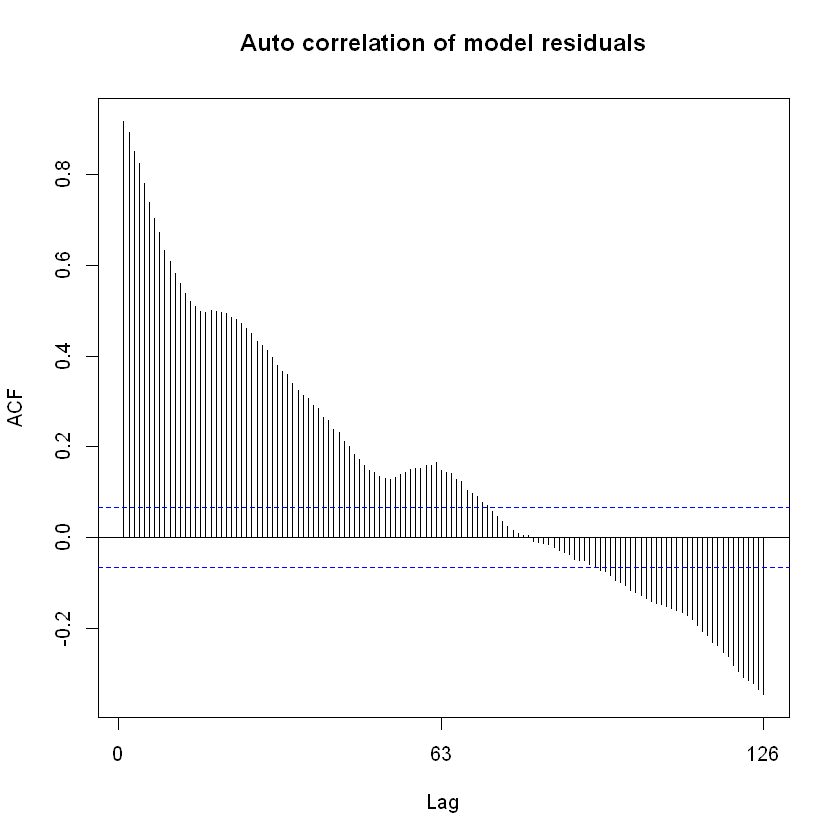

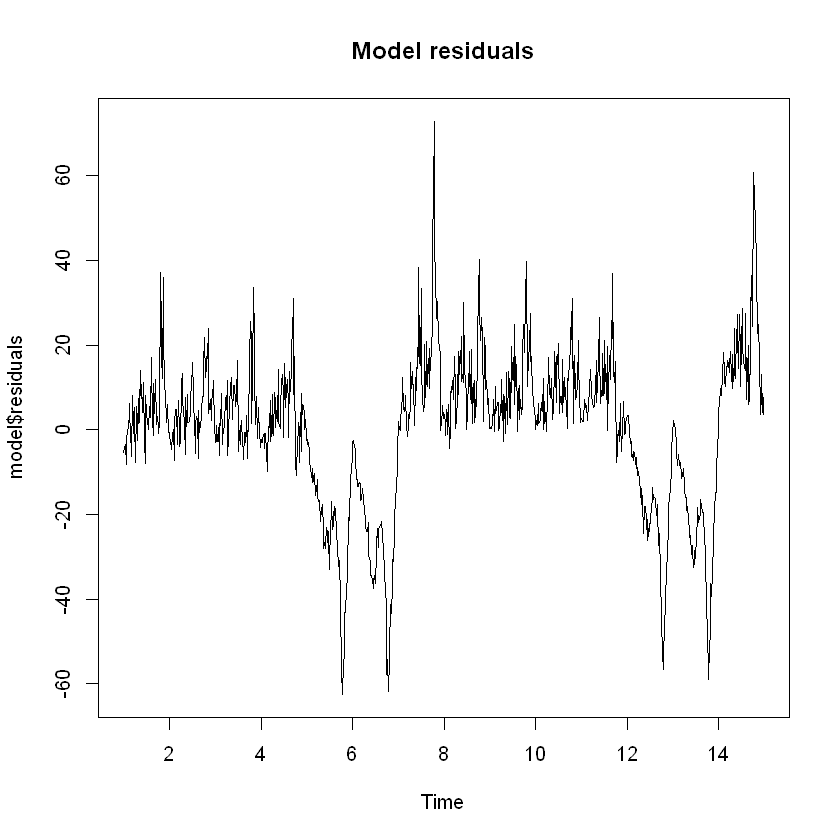

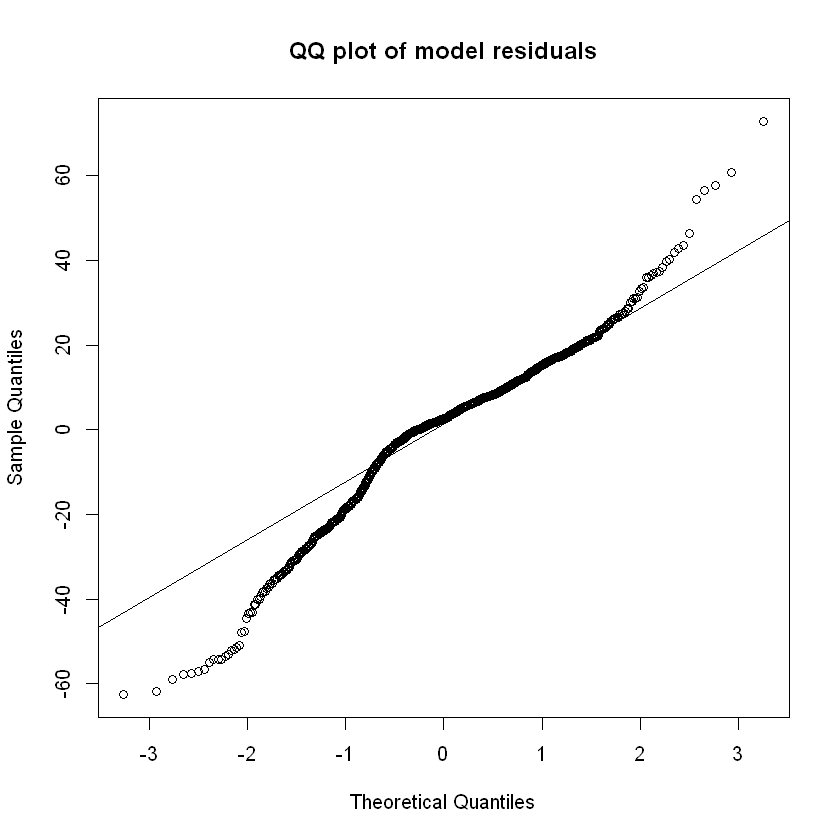

In [31]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(model$residuals,main='Auto correlation of model residuals')
plot(model$residuals,main='Model residuals')
qqnorm(model$residuals,main='QQ plot of model residuals')
qqline(model$residuals)

# ARIMA models

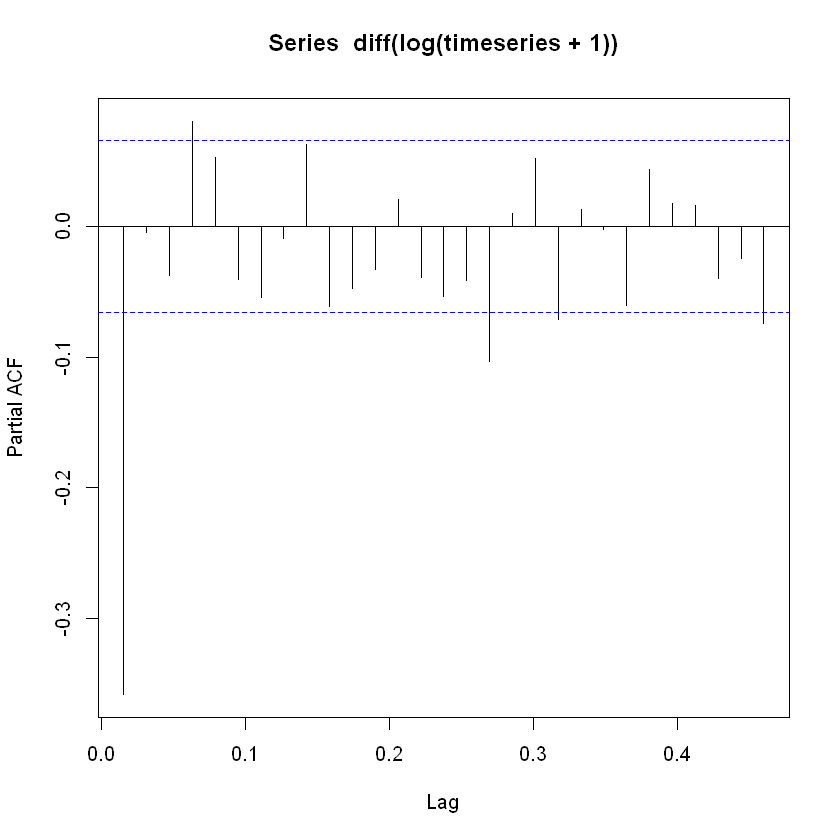

In [82]:
pacf(diff(log(timeseries+1)))  #p value 2

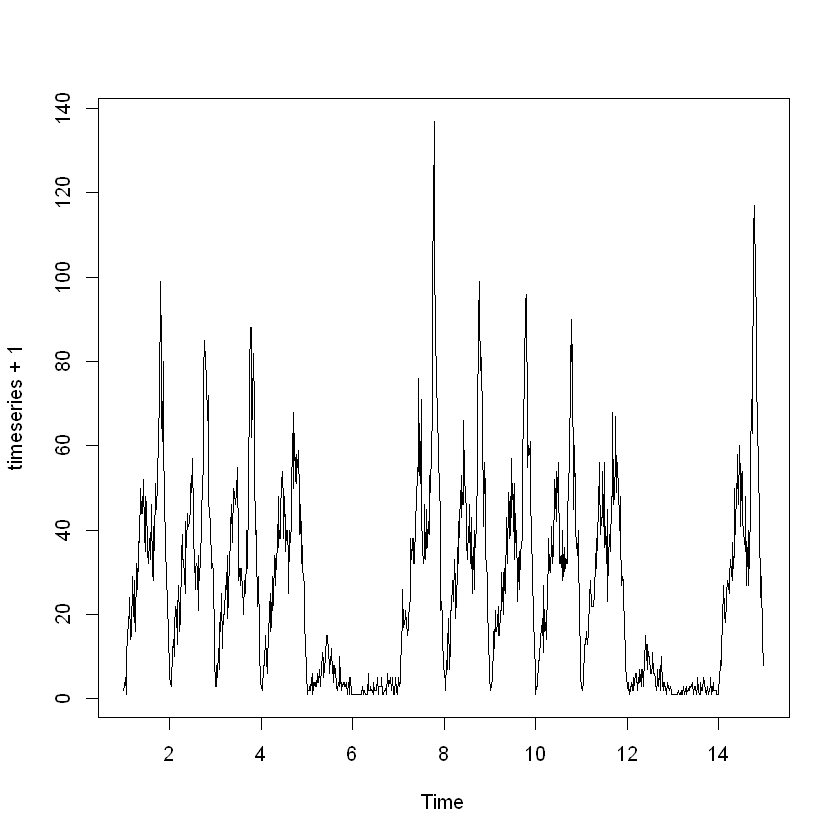

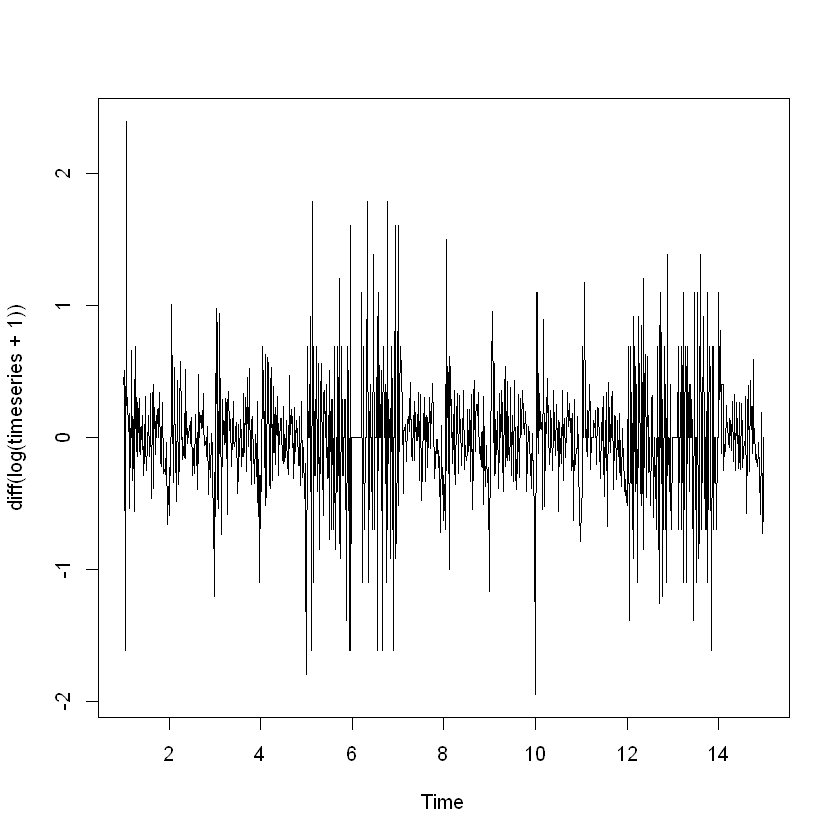

In [84]:
plot(timeseries+1)
plot(diff(log(timeseries+1)))  #D VALUE 0 OR 1

In [ ]:
c(0,1,2)

In [ ]:
fit<-arima(log(timeseries+1),c(1,0,2),seasonal = list(order = c(1,0,2), period = NA))


In [ ]:
pred<-predict(fit,n.ahead = 63*14) #14 day prediction
pred1<-2.718^pred$pred

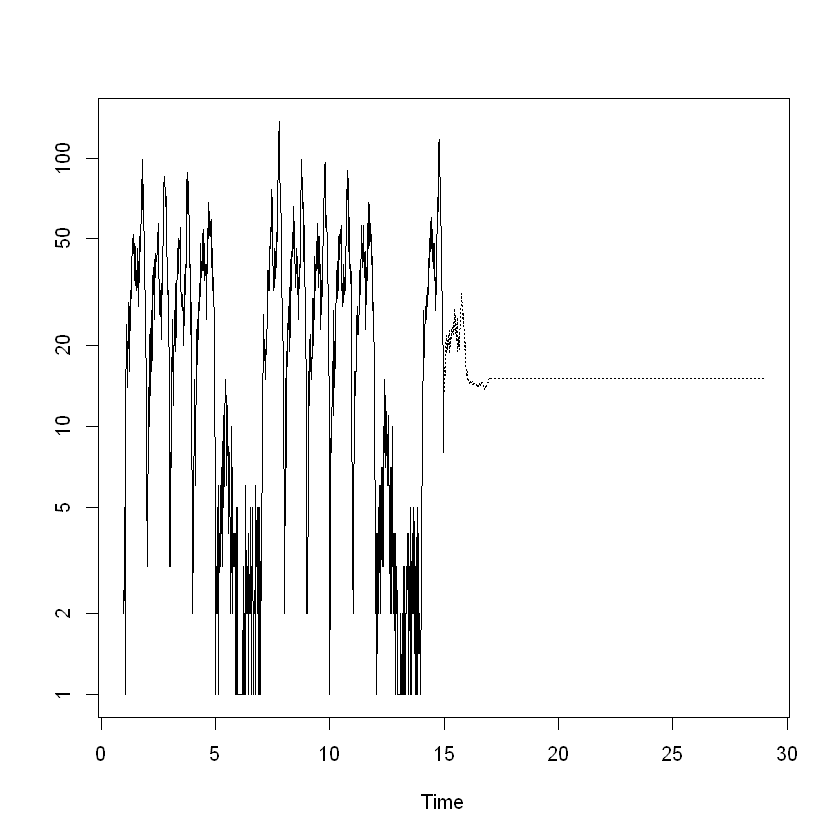

In [98]:
ts.plot(timeseries+1,pred1,log='y',lty=c(1,3))

In [19]:
model<-auto.arima(timeseries+1,ic="aic",trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)(1,0,1)[63] with non-zero mean : 6097.89
 ARIMA(0,0,0)            with non-zero mean : 8057.855
 ARIMA(1,0,0)(1,0,0)[63] with non-zero mean : 6156.125
 ARIMA(0,0,1)(0,0,1)[63] with non-zero mean : Inf
 ARIMA(0,0,0)            with zero mean     : 8802.017
 ARIMA(2,0,2)(0,0,1)[63] with non-zero mean : 6133.128
 ARIMA(2,0,2)(2,0,1)[63] with non-zero mean : Inf
 ARIMA(2,0,2)(1,0,0)[63] with non-zero mean : 6096.558
 ARIMA(1,0,2)(1,0,0)[63] with non-zero mean : 6096.779
 ARIMA(3,0,2)(1,0,0)[63] with non-zero mean : 6086.408
 ARIMA(3,0,1)(1,0,0)[63] with non-zero mean : 6085.032
 ARIMA(2,0,0)(1,0,0)[63] with non-zero mean : Inf
 ARIMA(4,0,2)(1,0,0)[63] with non-zero mean : 6086.867
 ARIMA(3,0,1)(1,0,0)[63] with zero mean     : 6101.943
 ARIMA(3,0,1)            with non-zero mean : 6130.27
 ARIMA(3,0,1)(2,0,0)[63] with non-zero mean : 6093.49
 ARIMA(3,0,1)(1,0,1)[63] with non-zero mean : 6087.009
 ARIMA(3,0,1)(2,0,1)[6

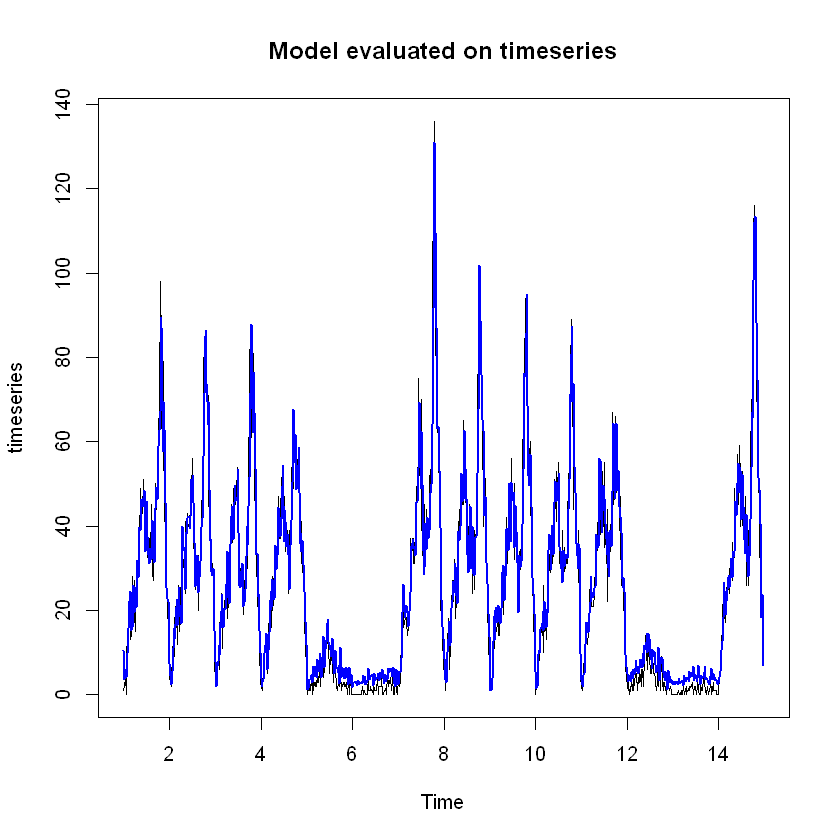

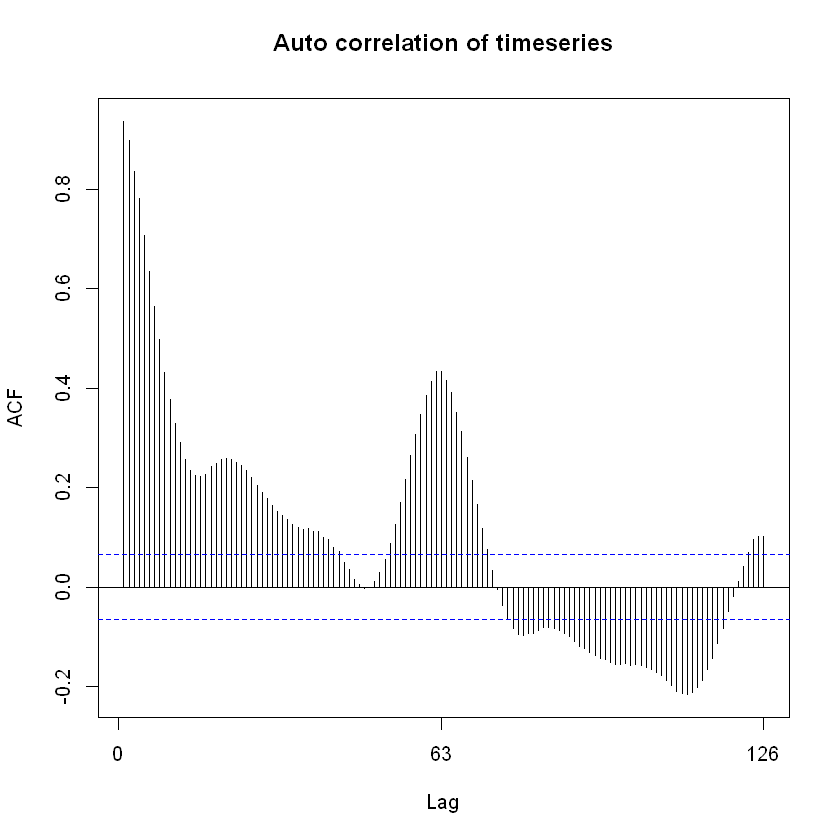

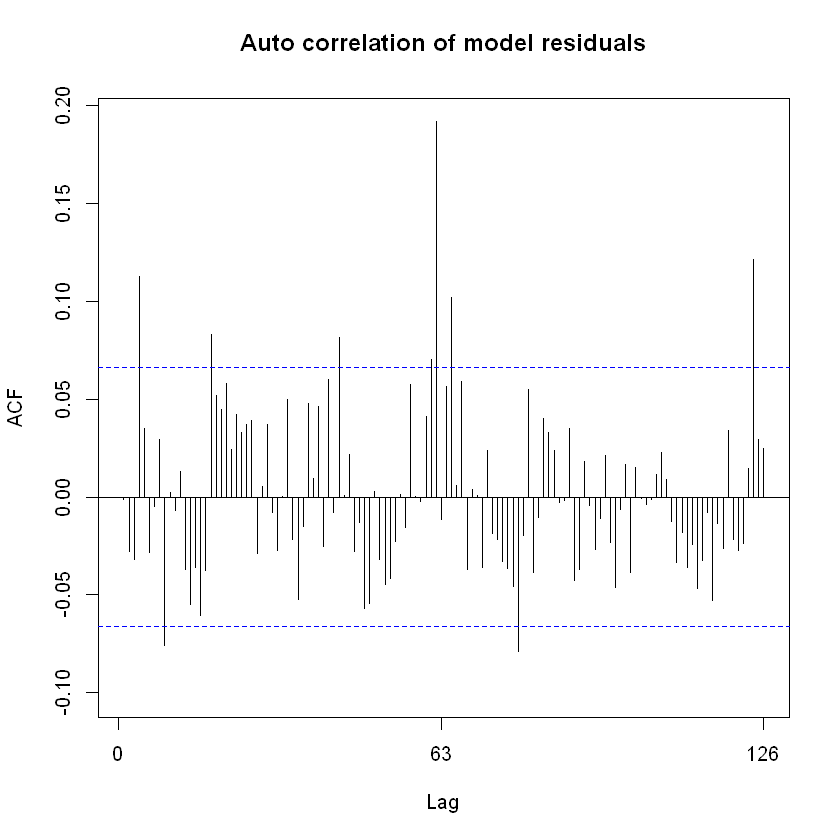

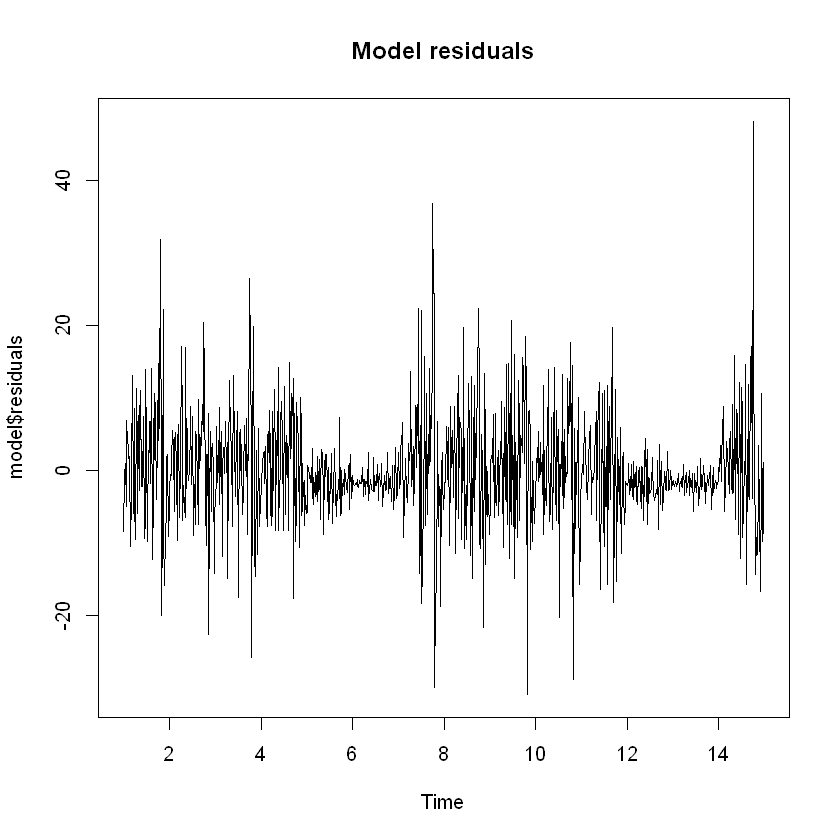

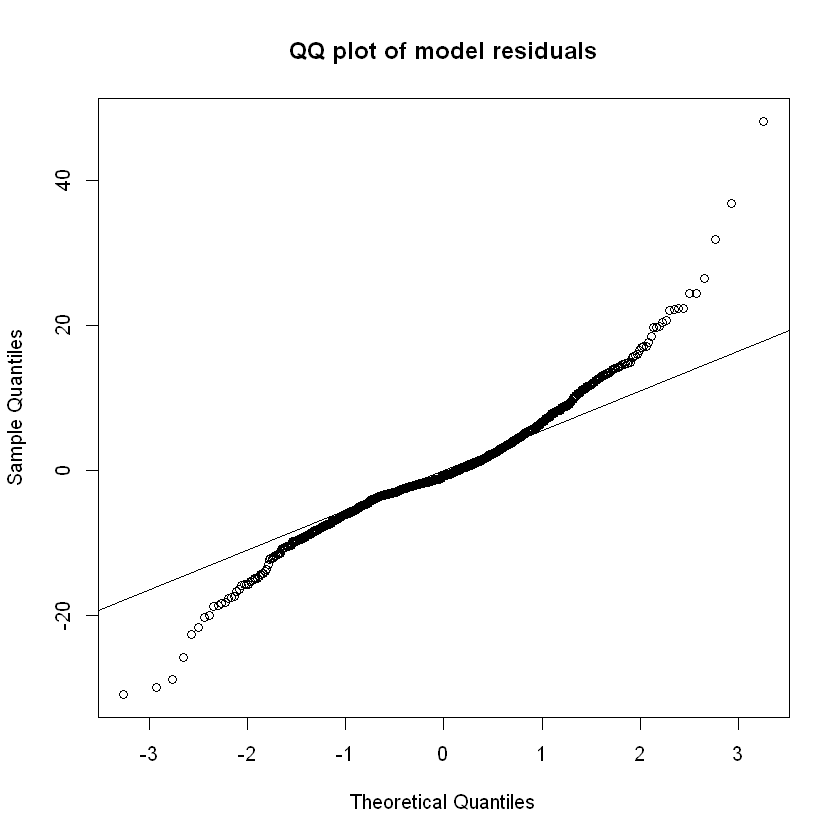

In [19]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(model$residuals,main='Auto correlation of model residuals')
plot(model$residuals,main='Model residuals')
qqnorm(model$residuals,main='QQ plot of model residuals')
qqline(model$residuals)

## Arima is actually not bad

In [30]:
model<-auto.arima(ts(timeseries,frequency=441),D=1)

In [31]:
myforecast<-forecast(model,h=63*7)

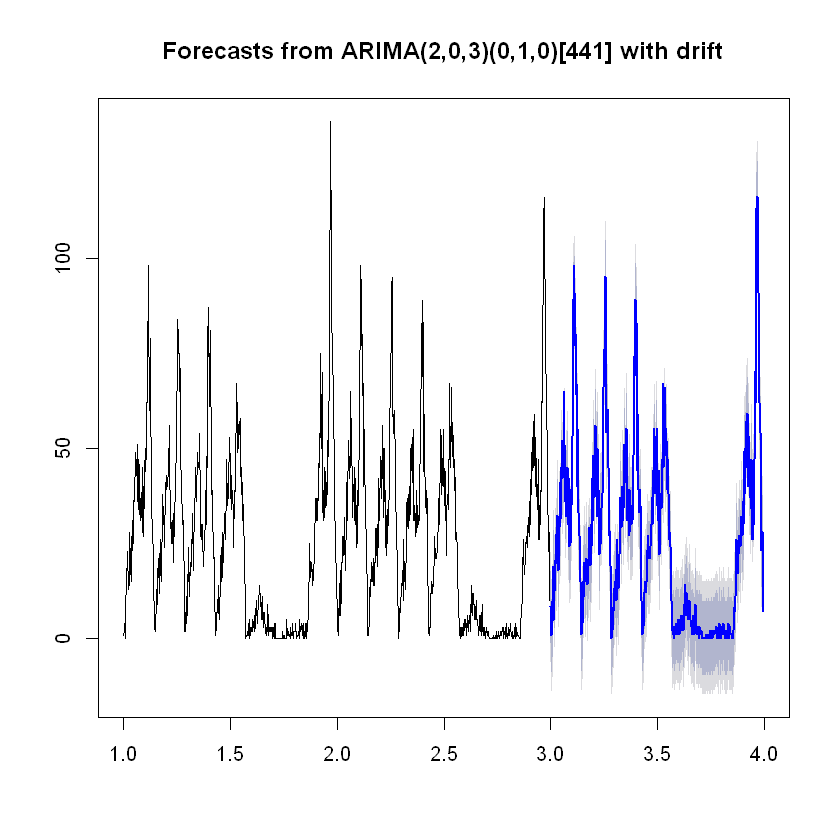

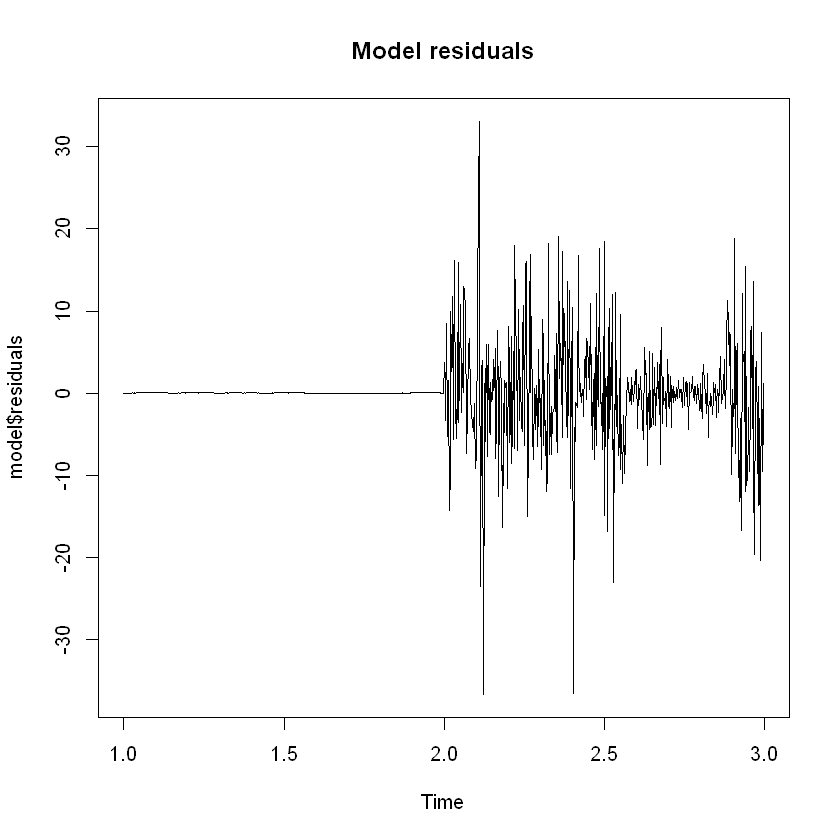

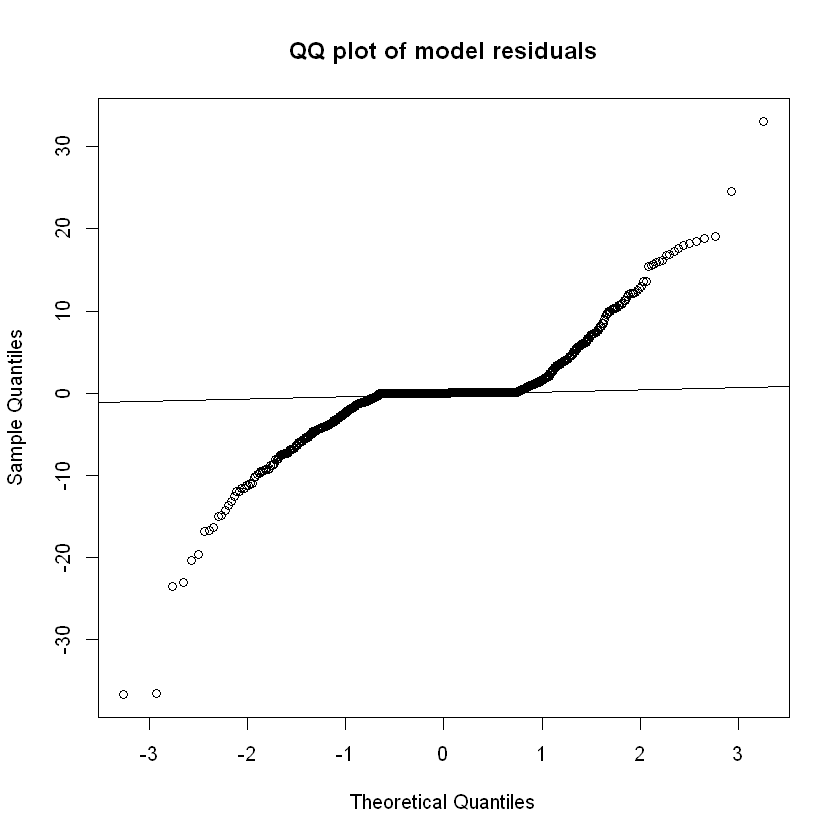

In [32]:
plot(myforecast)
plot(model$residuals,main='Model residuals')
qqnorm(model$residuals,main='QQ plot of model residuals')
qqline(model$residuals)

In [33]:
validresidabs<-abs(validation.set$demand - myforecast$mean)

MAE<-mean(validresidabs)
MAE

[1] 5.997239

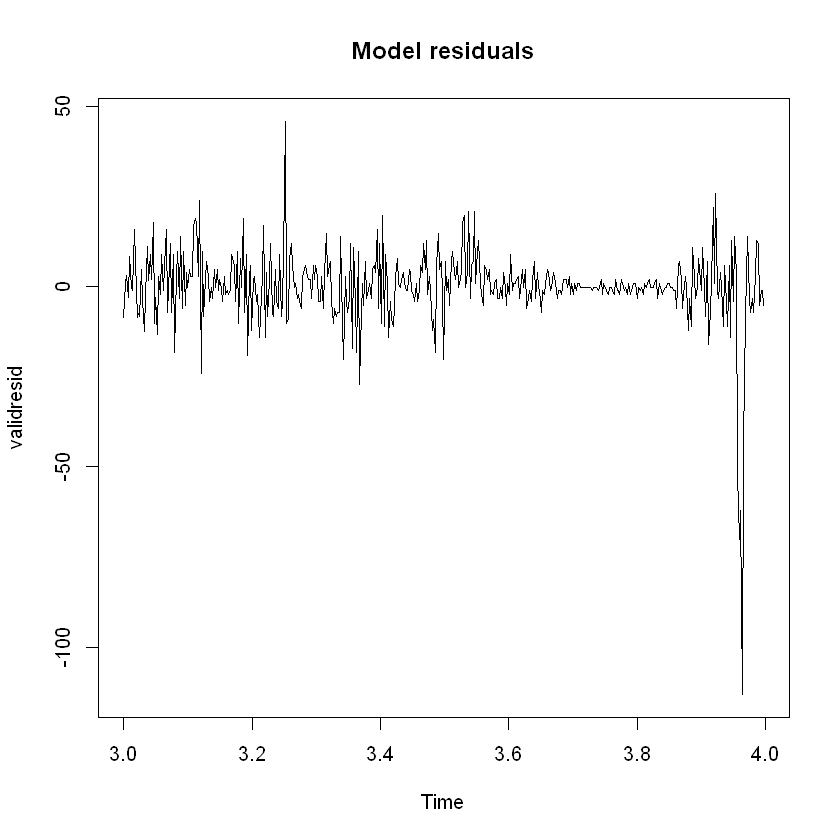

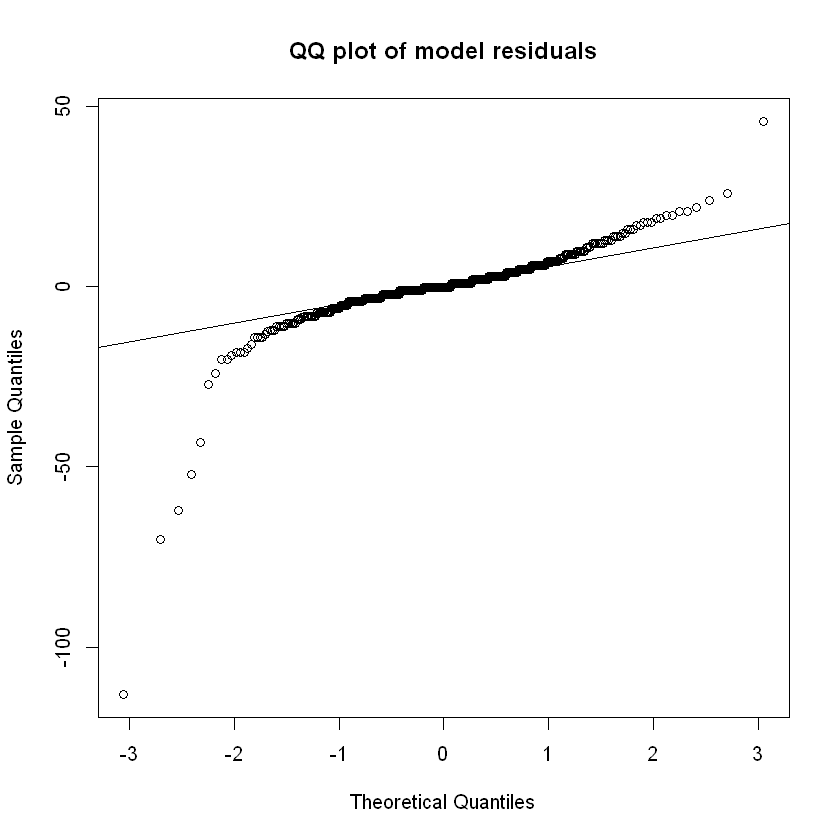

In [35]:
validresid<-validation.set$demand - myforecast$mean
plot(validresid,main='Model residuals')
qqnorm(validresid,main='QQ plot of model residuals')
qqline(validresid)

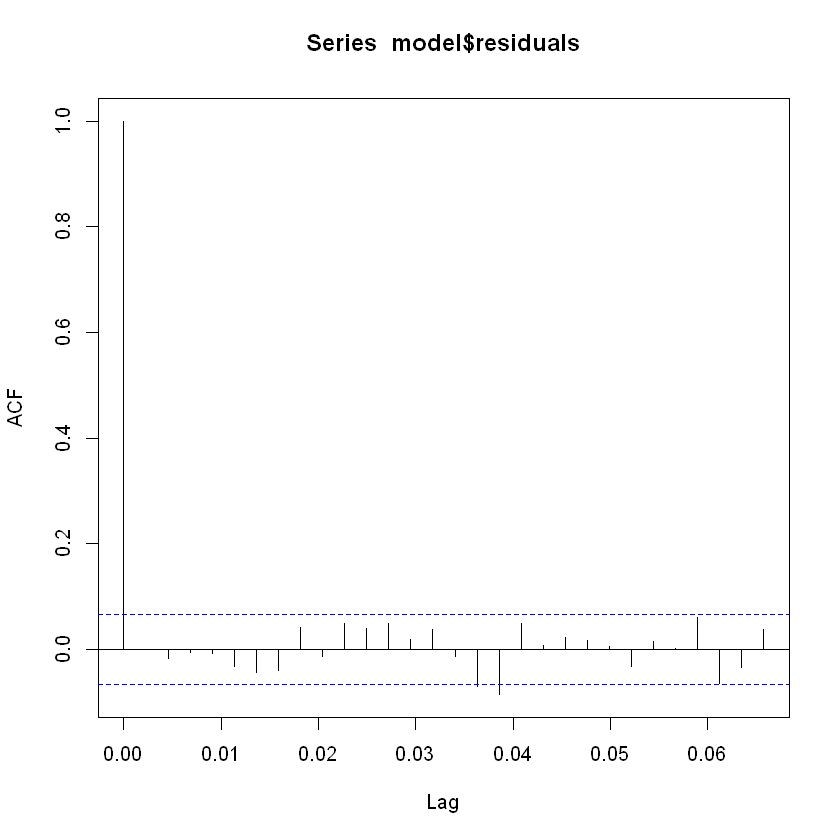

In [37]:
acf(model$residuals)

# TBATS model

In [19]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)
frequency(timeseries)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

[1] 63

In [20]:
multiple<-msts(timeseries, seasonal.periods=c(63,7*63))
frequency(multiple)

[1] 441

In [21]:
model<-tbats(multiple,seasonal.periods=c(63,7*63))

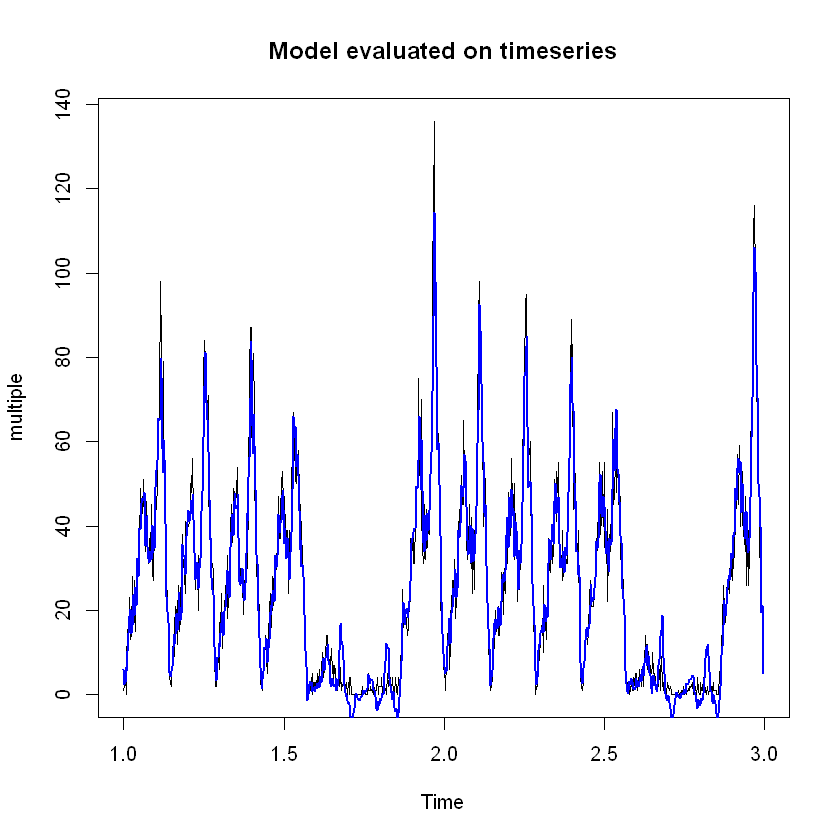

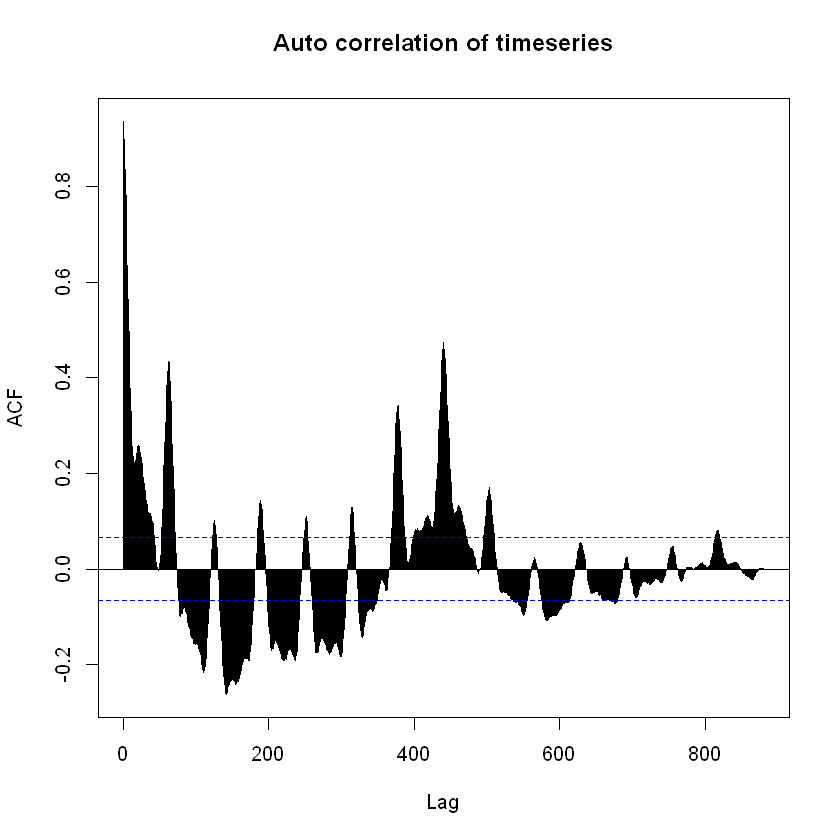

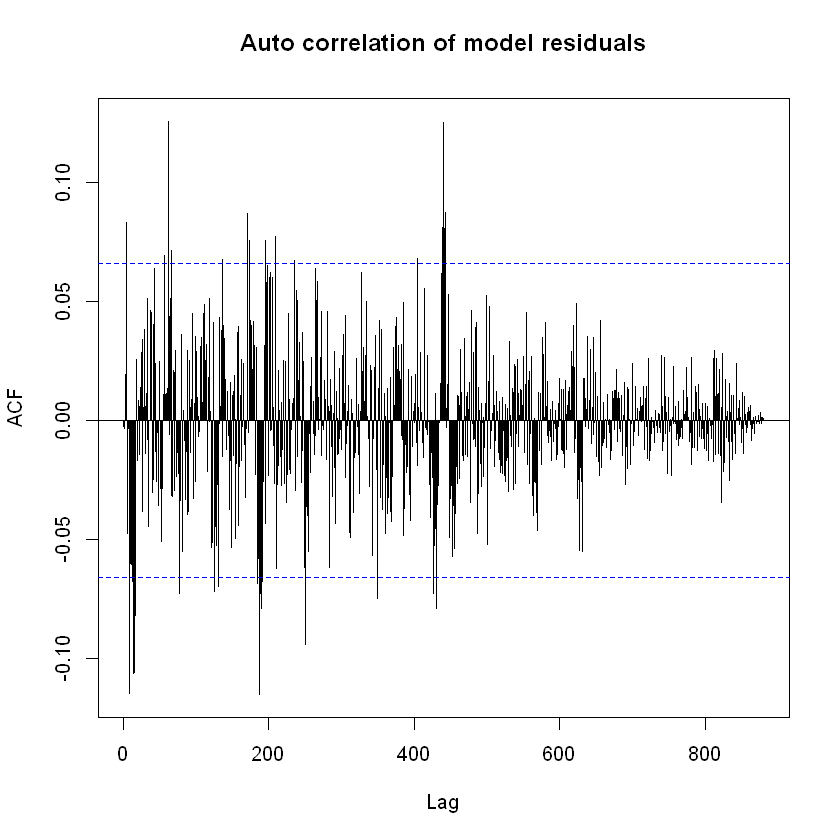

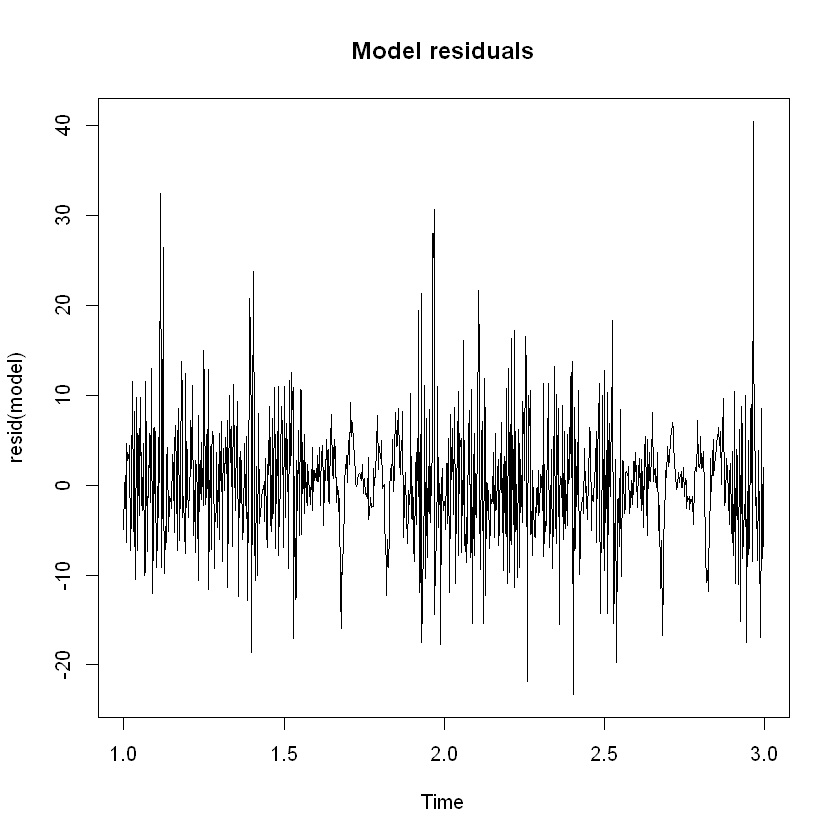

ERROR: Error: $ operator is invalid for atomic vectors


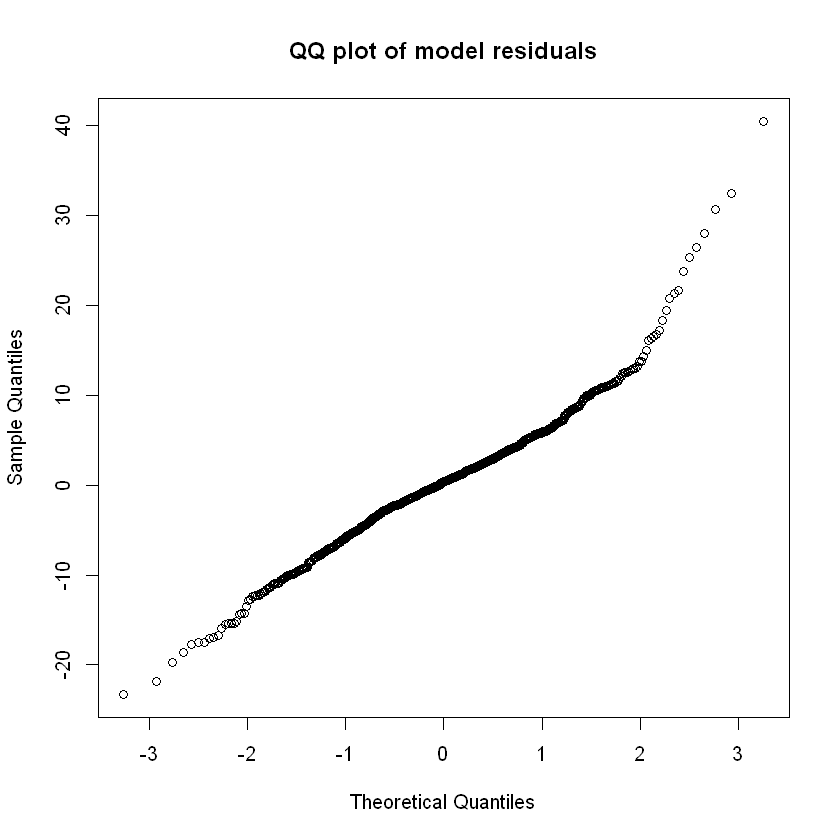

In [22]:
#coefficients(model)
coef<-coefficients(model)
plot(multiple,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(multiple,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

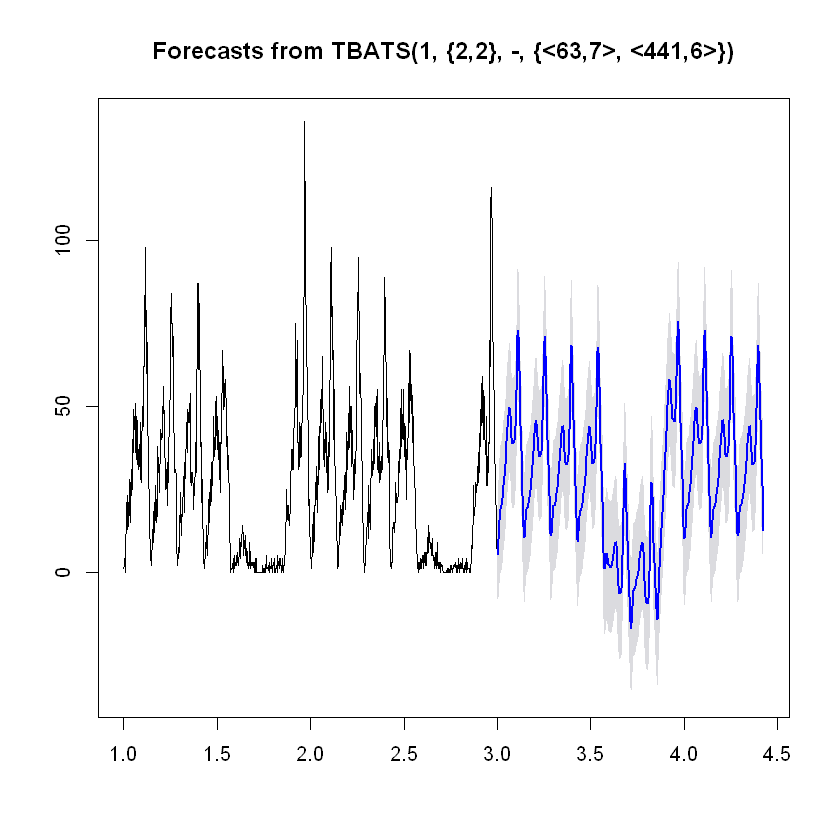

In [23]:
myforecast<-forecast(model,63*10,level = c(95))
plot(myforecast)

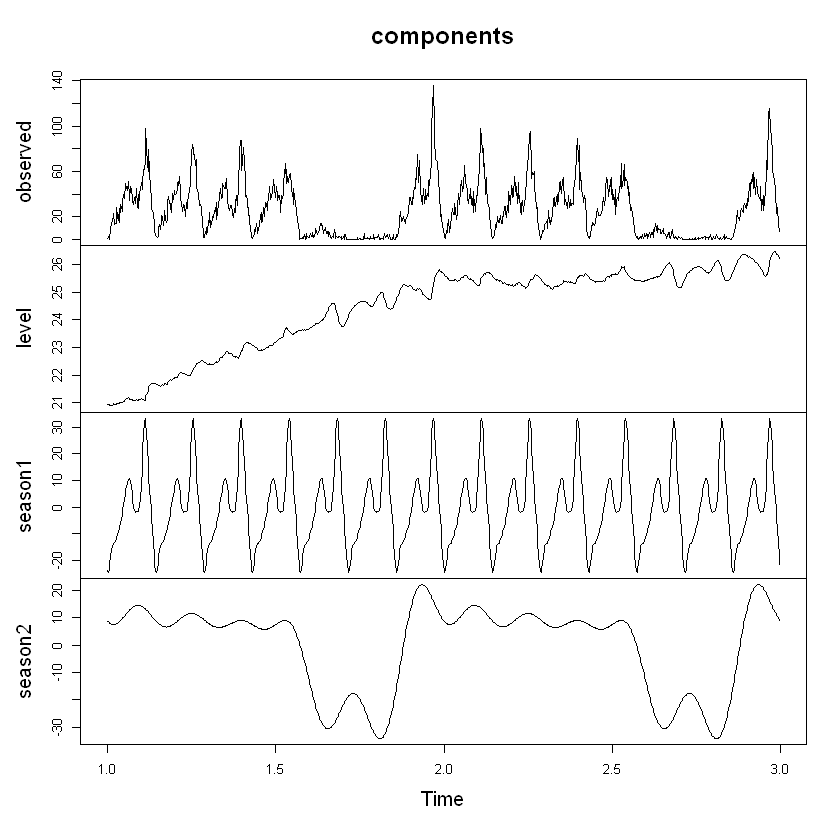

In [24]:
components <- tbats.components(model)
plot(components)

# Playing with TBATS parameters

In [25]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)
frequency(timeseries)

multiple<-msts(timeseries, seasonal.periods=c(63,7*63))
frequency(multiple)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

[1] 63

[1] 441

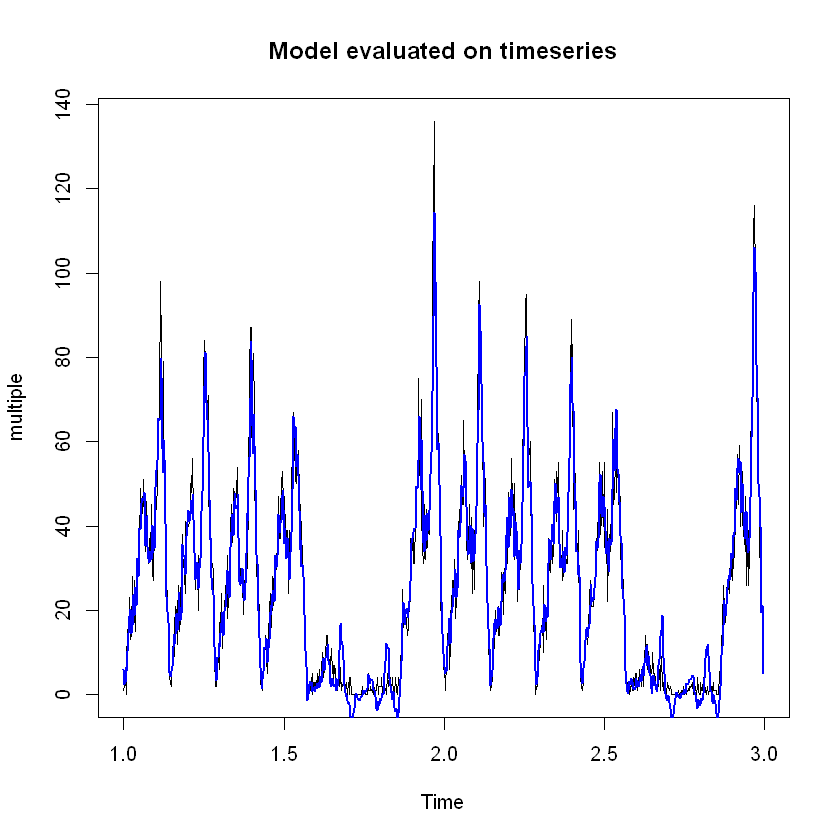

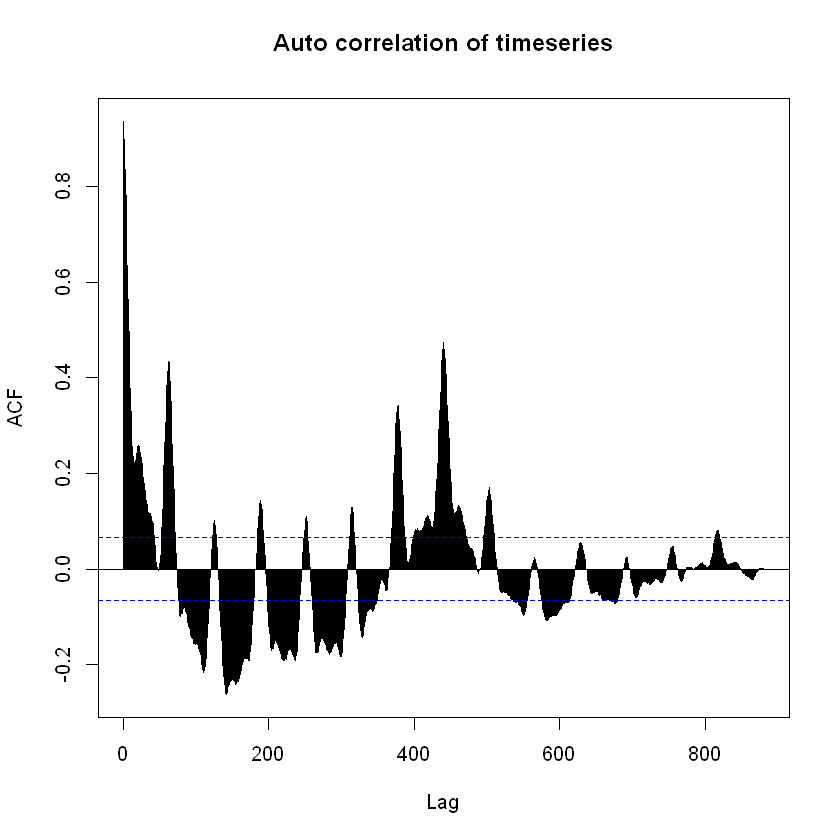

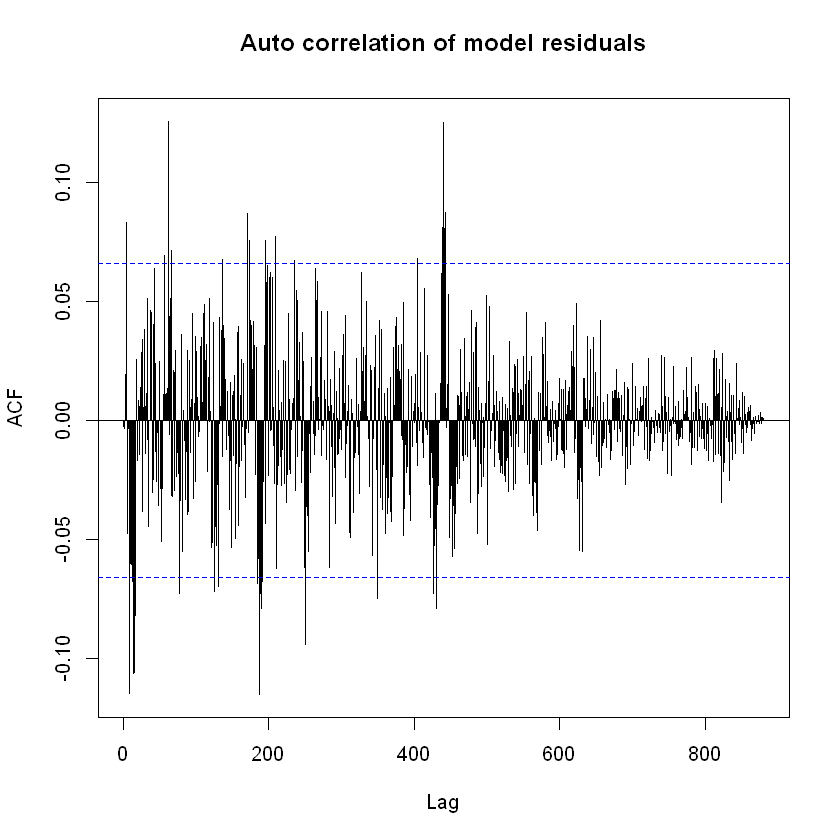

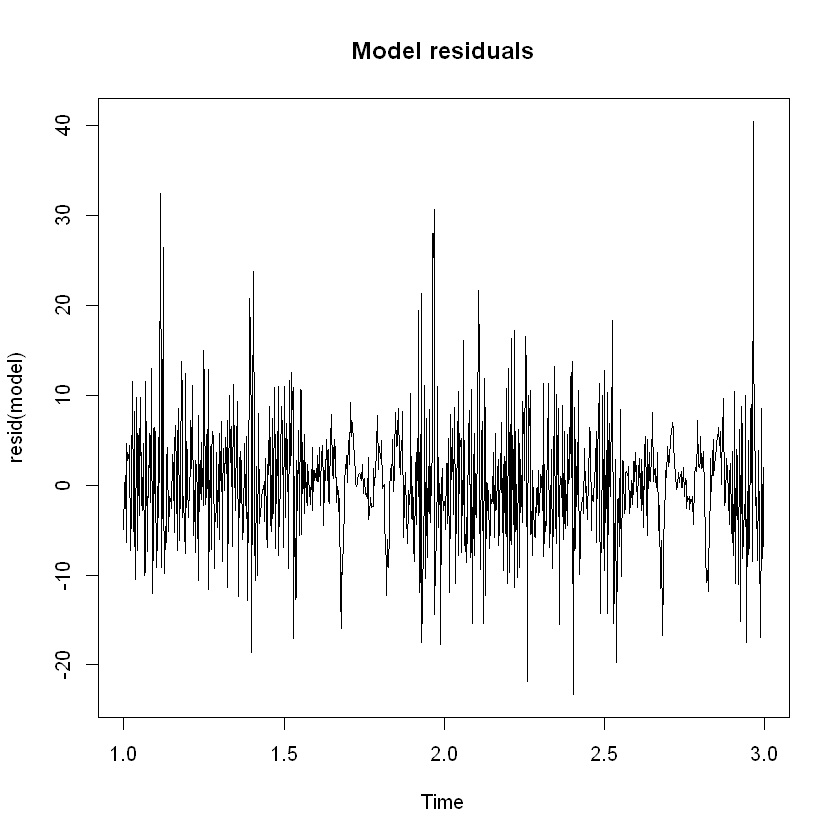

ERROR: Error: $ operator is invalid for atomic vectors


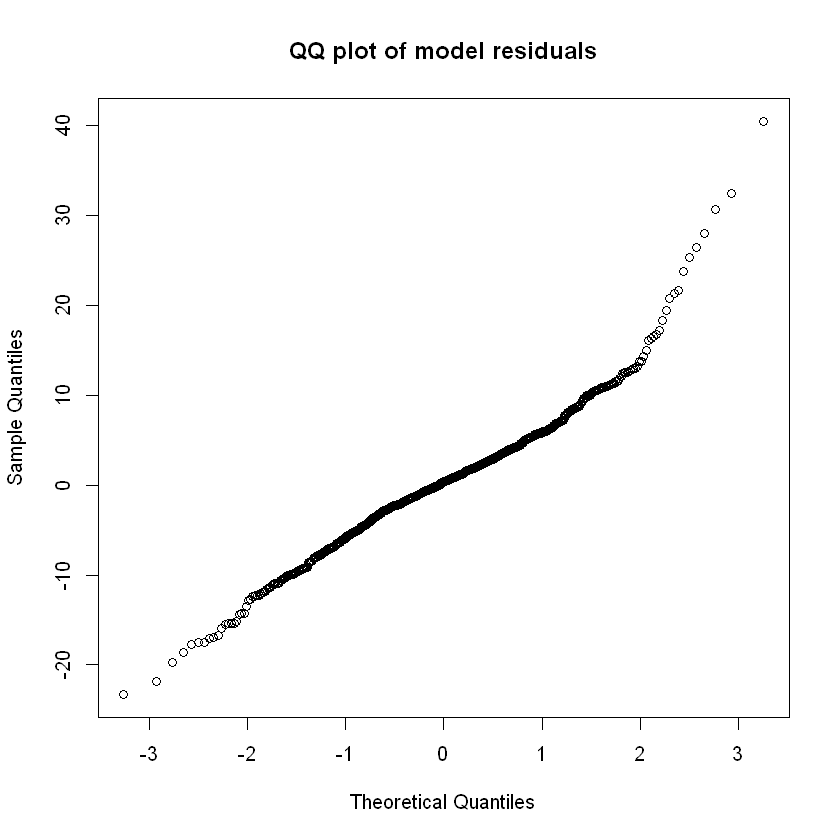

In [26]:
model<-tbats(multiple,seasonal.periods=c(63,7*63),use.box.cox = FALSE)

#coefficients(model)
coef<-coefficients(model)
plot(multiple,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(multiple,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

myforecast<-forecast(model,63*10,level = c(95))
plot(myforecast)

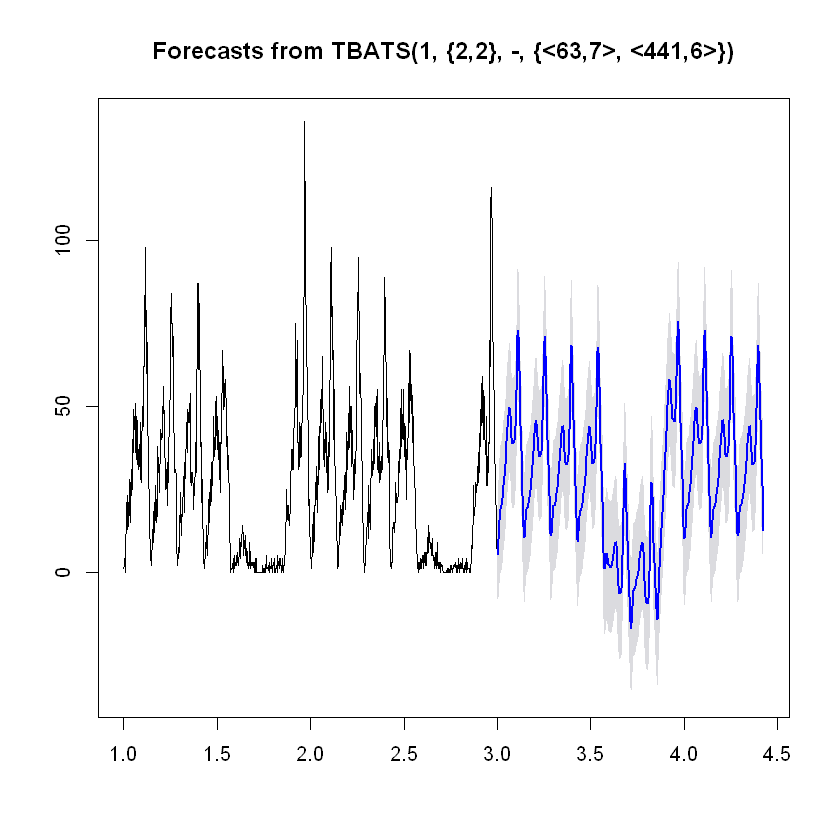

In [27]:
myforecast<-forecast(model,63*10,level = c(95))
plot(myforecast)

# TSLM with our own weekend dummy variable


We know the indexes of weekends.First weekend is indexes 253-378 and second weekend is indexes 694 - 819.We can confirm that.

In [31]:
training.set[((4*63)+1):(6*63),]

,date.and.time,demand
253,2005-03-05 06:30:00,0
254,2005-03-05 06:45:00,1
255,2005-03-05 07:00:00,1
256,2005-03-05 07:15:00,1
257,2005-03-05 07:30:00,2
258,2005-03-05 07:45:00,1
259,2005-03-05 08:00:00,4
260,2005-03-05 08:15:00,0
261,2005-03-05 08:30:00,5
262,2005-03-05 08:45:00,1


In [32]:
training.set[(((4+7)*63)+1):((6+7)*63),]

,date.and.time,demand
694,2005-03-12 06:30:00,2
695,2005-03-12 06:45:00,1
696,2005-03-12 07:00:00,3
697,2005-03-12 07:15:00,0
698,2005-03-12 07:30:00,1
699,2005-03-12 07:45:00,3
700,2005-03-12 08:00:00,3
701,2005-03-12 08:15:00,1
702,2005-03-12 08:30:00,4
703,2005-03-12 08:45:00,1


In [33]:
daytype<-rep("weekday",882)
daytype[253:378]<-"weekend"
daytype[694:819]<-"weekend"
which(daytype=="weekend")

[1] 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 [19] 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 [37] 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 [55] 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 [73] 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 [91] 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
[109] 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
[127] 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711
[145] 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729
[163] 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
[181] 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765
[199] 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783
[217] 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801
[235] 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819

In [15]:
model<-tslm(timeseries ~ season)
summary(model)


Call:
tslm(formula = timeseries ~ season)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.786  -8.339   3.643  10.714  73.214 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7857     5.1034   0.350 0.726499    
season2      -0.2143     7.2173  -0.030 0.976321    
season3       1.0000     7.2173   0.139 0.889835    
season4       1.7857     7.2173   0.247 0.804645    
season5       5.5714     7.2173   0.772 0.440365    
season6       7.1429     7.2173   0.990 0.322621    
season7      10.5714     7.2173   1.465 0.143378    
season8       8.9286     7.2173   1.237 0.216403    
season9      10.5000     7.2173   1.455 0.146098    
season10      9.5714     7.2173   1.326 0.185151    
season11      9.8571     7.2173   1.366 0.172388    
season12     13.8571     7.2173   1.920 0.055207 .  
season13     13.5000     7.2173   1.871 0.061771 .  
season14     12.9286     7.2173   1.791 0.073610 .  
season15     13.2857     7.2173   1.841 0.066011 .  


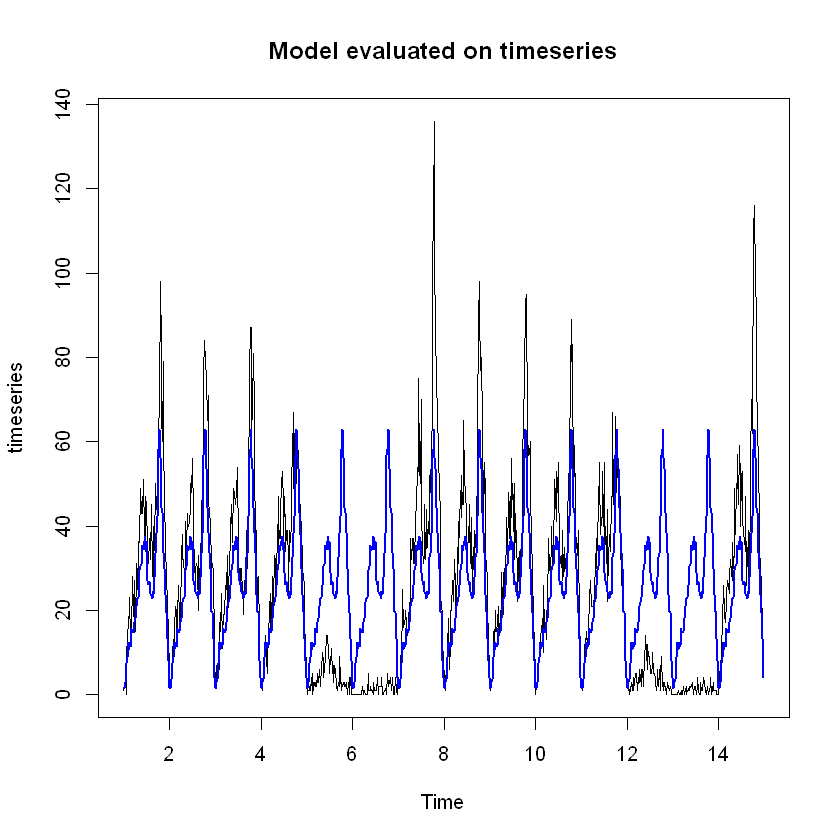

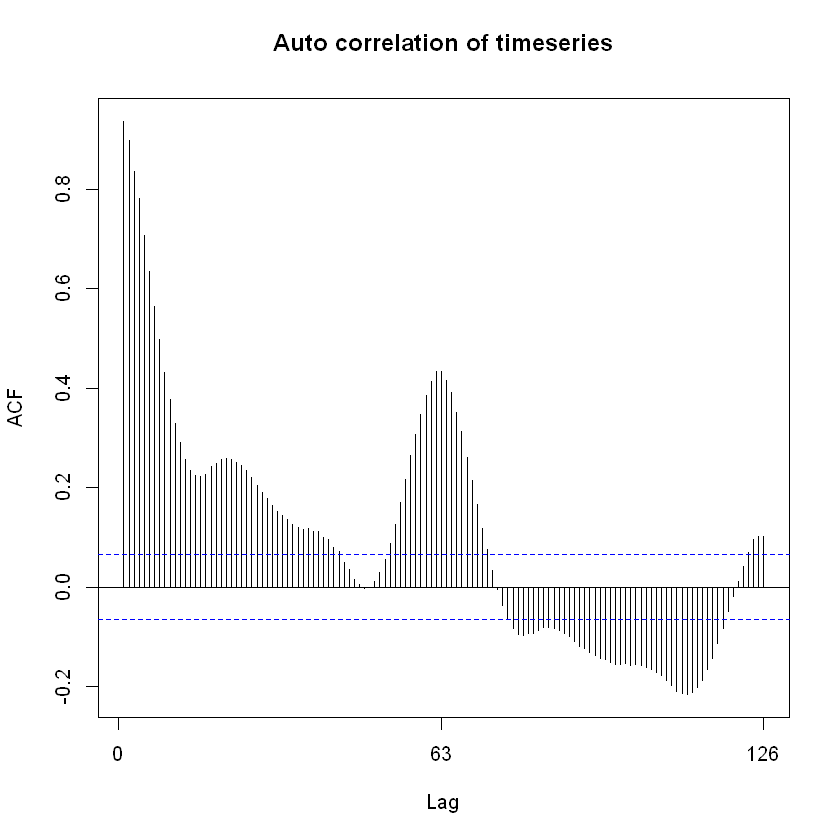

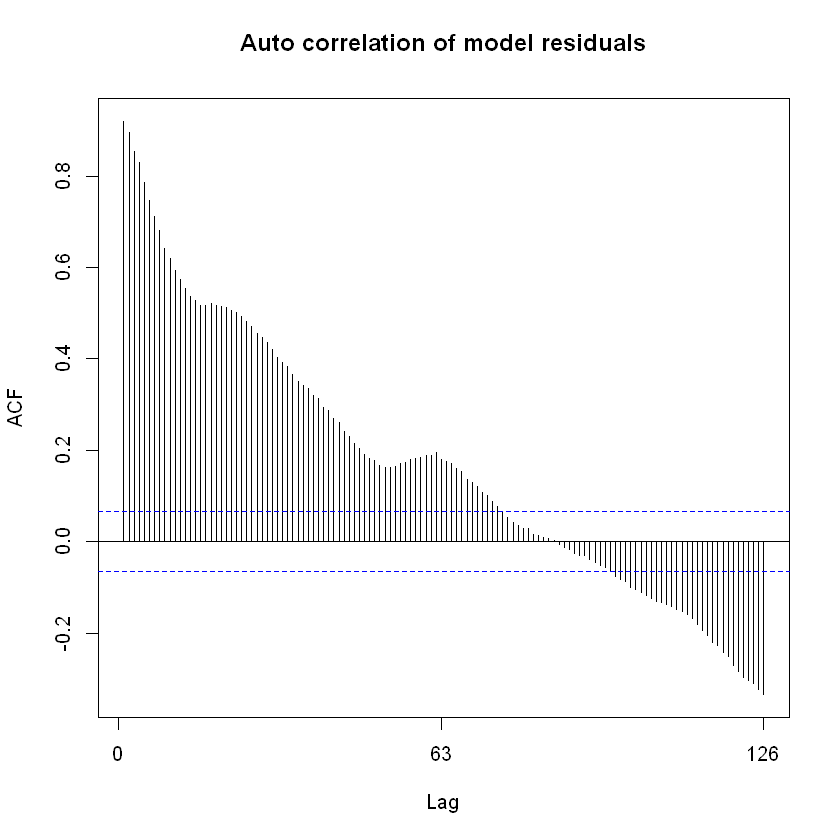

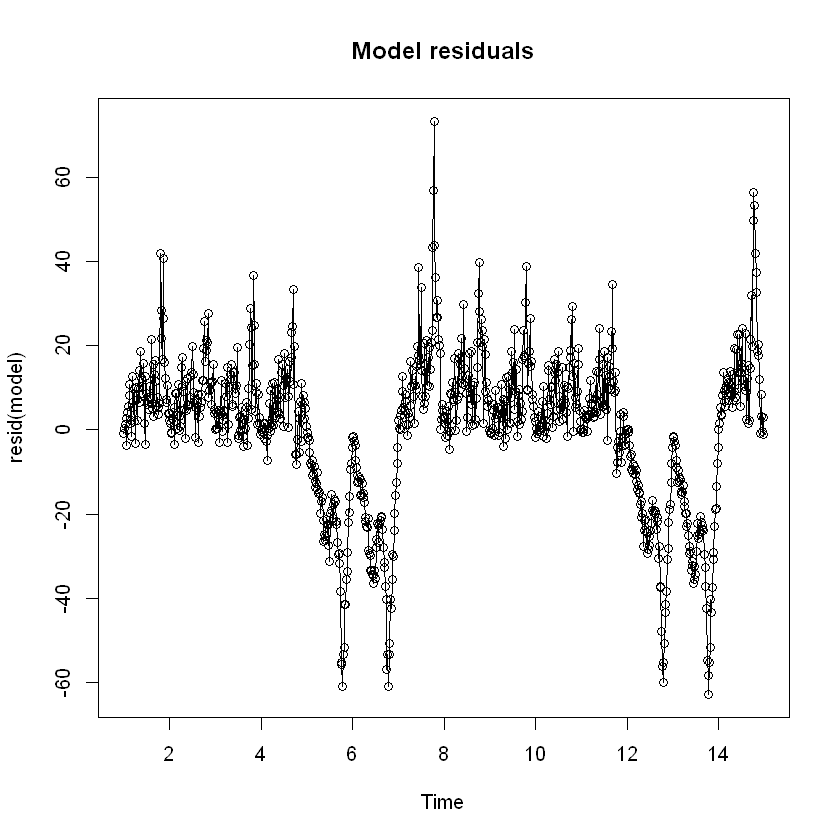

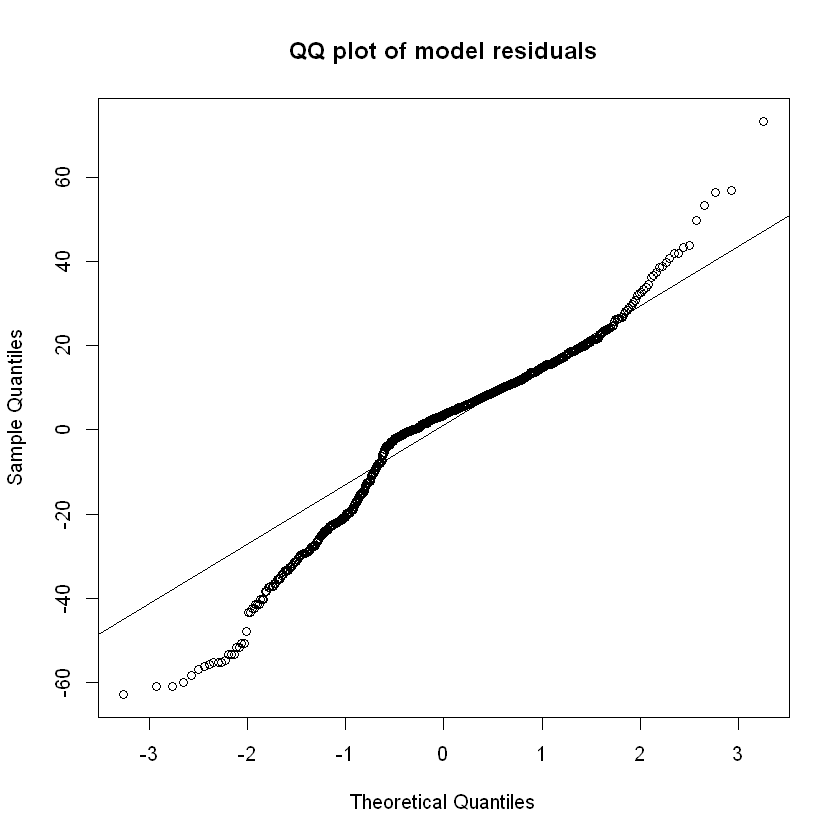

In [16]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals',type='o')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

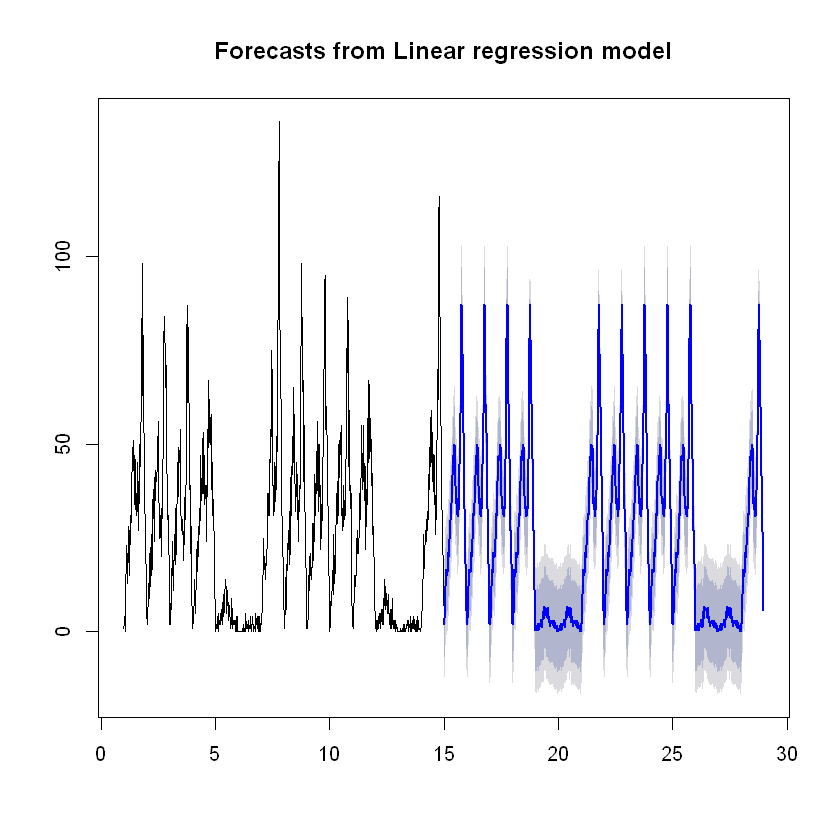

In [195]:
pred<-forecast(model,h= 63*14) #14 day prediction ONLY 14 WORKS RIP
plot(pred)

# Links -References

- https://stats.stackexchange.com/questions/29477/how-to-write-a-linear-model-formula-with-100-variables-in-r?fbclid=IwAR3mkIuSoUFd-T-LKObuZZ9VVqLl5iooS25rcexFA9LHjpRcwLzezew3S7E 


- https://robjhyndman.com/hyndsight/forecasting-weekly-data/?fbclid=IwAR2PF5G4gv5MQJIaa7rOK00V0Y-mjV21hovaEU4UDw-njTwe2D6JP4Te3YA


- https://robjhyndman.com/publications/complex-seasonality/?fbclid=IwAR1rIpcUTmpHa9Um0Nq7FAFkc3DwPC6XO2brLix08NWIxWyGCwpW40WTtd0 


- Using residuals to improve forecasts   https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/?fbclid=IwAR3Vb00DPHgTGc8FYvOsXlxtcpEQdcA-7r7pWuclTJQzbDvg-Gha-mXpX_8

- TBATS model https://yintingchou.com/posts/bats-and-tbats-model/  
- TBATS DOC https://www.rdocumentation.org/packages/forecast/versions/8.4/topics/tbats

- facebooks prophet https://cran.r-project.org/web/packages/prophet/vignettes/quick_start.html  

- another good paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.450.8320&rep=rep1&type=pdf 


-  https://robjhyndman.com/hyndsight/forecasting-weekly-data/ 

 
- https://stats.stackexchange.com/questions/46246/conditional-model-using-function-tslm-in-r-package-forecast